## Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import warnings
import scorecardpy as sc
from string import ascii_letters

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

application = pd.read_csv('/Users/henryzeng/Desktop/UWO Courses/Banking Analytics/Project 2/coursework2_datasets/coursework2_application_sampled.csv')
performance = pd.read_csv('/Users/henryzeng/Desktop/UWO Courses/Banking Analytics/Project 2/coursework2_datasets/coursework2_performance_data_sampled.csv')

# merge the data from the two csvs
data_full = performance.merge(application, on='LOAN SEQUENCE NUMBER', how='left')

# change monthly reoprting period to datetime
data_full['MONTHLY REPORTING PERIOD'] = pd.to_datetime(data_full['MONTHLY REPORTING PERIOD'], format='%Y%m')

# if column value is RA then it is 3
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 3 if x == 'RA' else x)

# change to int
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype(int)
# change the column CURRENT LOAN DELINQUENCY STATUS
# slide 13 4 intro to analytics
# if value is less then 3 then it is 0 # else it is 1 # zero represents no default # one represents default
data_full['DEFAULT'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x < 3 else 1)

########### data cleaning ###########
# if zero balance code is 1 then remove the row
data_full = data_full[~(data_full['ZERO BALANCE CODE'] == 1)]

# remove the rows where CURRENT ACTUAL UPB is 0
data_full = data_full[~(data_full['CURRENT ACTUAL UPB'] == 0)]

data_full['CUMULATIVE MODIFICATION COST'].fillna(0, inplace=True)
data_full['STEP MODIFICATION FLAG'].fillna('Not modified', inplace=True)
data_full['PAYMENT DEFERRAL'].fillna('Not payment deferral', inplace=True)
data_full['DELINQUENT ACCRUED INTEREST'].fillna(0, inplace=True)
data_full['DELINQUENCY DUE TO DISASTER'].fillna('N', inplace=True)
data_full['BORROWER ASSISTANCE STATUS CODE'].fillna('N', inplace=True)
data_full['CURRENT MONTH MODIFICATION COST'].fillna(0, inplace=True)
data_full['RELIEF REFINANCE INDICATOR'].fillna('N', inplace=True)
data_full['SUPER CONFORMING FLAG'].fillna('N', inplace=True)
data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'].fillna('unknown', inplace=True)

# drop DEFECT SETTLEMENT DATE
data_full.drop(columns=['DEFECT SETTLEMENT DATE'], inplace=True)

# drop the columns with more than 90% missing values
data_full = data_full.loc[:, data_full.isnull().mean() <= 0.9]

# drop the rows with all 0 values
data_full = data_full.loc[:, (data_full != 0).any(axis=0)]

# Replace specific missing values with 'np.nan'
missing_value_map = {
    'CREDIT SCORE': [9999],
    'FIRST TIME HOMEBUYER FLAG': [9],
    'MI PERCENT': [999],
    'NUMBER OF UNITS': [99],
    'OCCUPANCY STATUS': [9],
    'ORIGINAL CLTV': [999],
    'ORIGINAL DTI RATIO': [999],
    'ORIGINAL LTV': [999],
    'CHANNEL': [9],
    'PROPERTY TYPE': [99],
    'LOAN PURPOSE': [9],
    'NUMBER OF BORROWERS': [99],
    'PROGRAM INDICATOR': [9],
    'PROPERTY VALUATION METHOD': [9],
    'MI CANCELLATION INDICATOR': [9, 7]
}

for column, values in missing_value_map.items():
    if column in data_full.columns:
        data_full[column] = data_full[column].replace(values, np.nan)


# List of columns to convert to datetime
date_columns = [
    'MONTHLY REPORTING PERIOD', 
    'FIRST PAYMENT DATE', 
    'MATURITY DATE'
]

# Convert the specified columns to datetime
for column in date_columns:
    if column in data_full.columns:
        data_full[column] = pd.to_datetime(data_full[column], errors='coerce')

###### feature engineering ########

# add boolean for whether loan in delinquency or not 
data_full['DELINQUENCY'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x : 1 if x != 0 else 0)

# cum sum of the delinquency status
data_full['DEFAULT CUM SUM'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DEFAULT'].cumsum()

# last month current loan deliquency status
data_full['LAST MONTH DELINQUENCY STATUS'] = data_full.groupby('LOAN SEQUENCE NUMBER')['CURRENT LOAN DELINQUENCY STATUS'].shift(1).fillna(0)

# rolling 12 months time in deliquency
data_full['MONTHS IN DELINQUENCY PAST 12'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DELINQUENCY'].rolling(12, min_periods=1).sum().reset_index(drop=True)

# make a function that takes in a pd.series of zeroes and ones and then returns a new series with every 12 before the ones being ones as well
def default_next_12(default_vector):
     
    if np.where(default_vector==1)[0].size==0:
        return default_vector
     
    first_default = np.where(default_vector==1)[0][0]
    defualt_next_12_vector = np.zeros(len(default_vector))
    defualt_next_12_vector[max(0,first_default-12):] = 1

    return(defualt_next_12_vector)

default_next_12_col = []

# group the data by LOAN SEQUENCE NUMBER
for _, group in data_full.groupby('LOAN SEQUENCE NUMBER'):
    default_next_12_series = default_next_12(group['DEFAULT'])

    default_next_12_col.extend(default_next_12_series)

data_full['DEFAULT_NEXT_12'] = [x == 1 for x in default_next_12_col]

# remove rows where the cumsum != 0
data_full = data_full[data_full['DEFAULT CUM SUM'] == 0]

# make training data
data_full_train = data_full[data_full['MONTHLY REPORTING PERIOD'] < '2022-06-01']

# make out of time data
data_full_oot = data_full[data_full['MONTHLY REPORTING PERIOD'] == '2023-06-01']

data_full.head()

,LOAN SEQUENCE NUMBER,MONTHLY REPORTING PERIOD,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,REMAINING MONTHS TO LEGAL MATURITY,CURRENT INTEREST RATE,CURRENT NON-INTEREST BEARING UPB,CUMULATIVE MODIFICATION COST,STEP MODIFICATION FLAG,...,RELIEF REFINANCE INDICATOR,PROPERTY VALUATION METHOD,INTEREST ONLY INDICATOR (I/O INDICATOR),MI CANCELLATION INDICATOR,DEFAULT,DELINQUENCY,DEFAULT CUM SUM,LAST MONTH DELINQUENCY STATUS,MONTHS IN DELINQUENCY PAST 12,DEFAULT_NEXT_12
0,F14Q10000351,2021-01-01,194781.21,0,83,277,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False
1,F14Q10000351,2021-02-01,194383.73,0,84,276,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False
2,F14Q10000351,2021-03-01,193984.68,0,85,275,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False
3,F14Q10000351,2021-04-01,193584.05,0,86,274,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False
4,F14Q10000351,2021-05-01,193181.83,0,87,273,4.75,0.0,0.0,Not modified,...,N,NaN,N,9,0,0,0,0.0,0.0,False


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = data_full_train.drop(columns=['DEFAULT_NEXT_12', 'MONTHLY REPORTING PERIOD', 'LOAN SEQUENCE NUMBER',
                                  'DEFAULT', 'DEFAULT CUM SUM', 'MATURITY DATE', 'SELLER NAME', 'FIRST PAYMENT DATE', 'SERVICER NAME',
                                  ])
y = data_full_train['DEFAULT_NEXT_12']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

data_full['NUMBER OF UNITS'] = data_full['NUMBER OF UNITS'].astype(float)
data_full['NUMBER OF BORROWERS'] = data_full['NUMBER OF BORROWERS'].astype(float)

## Weight of Evidence

In [5]:
ordered_vars = [
    'CREDIT SCORE',
    'ORIGINAL UPB',
    'ORIGINAL INTEREST RATE',
    'ORIGINAL LOAN-TO-VALUE (LTV)',
    'ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)',
    'ORIGINAL DEBT-TO-INCOME (DTI) RATIO',
    'ORIGINAL LOAN TERM',
    'MORTGAGE INSURANCE PERCENTAGE (MI %)',
    'ESTIMATED LOAN TO VALUE (ELTV)',
    'CURRENT ACTUAL UPB',
    'CURRENT INTEREST RATE',
    'INTEREST BEARING UPB',
    'CURRENT NON-INTEREST BEARING UPB',
    'LOAN AGE',
    'REMAINING MONTHS TO LEGAL MATURITY',
    'NUMBER OF UNITS',
    'NUMBER OF BORROWERS'
]

ordered_vars += [
    'DELINQUENCY',
    'LAST MONTH DELINQUENCY STATUS',
    'MONTHS IN DELINQUENCY PAST 12'
]

In [9]:
import scorecardpy as sc
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# combine X and y to make a new dataframe
X_train = pd.concat([X_train, y_train], axis=1)
X_test= pd.concat([X_test, y_test], axis=1)

X_train_bin = X_train[ordered_vars + ['DEFAULT_NEXT_12']].copy()
X_test_bin = X_test[ordered_vars + ['DEFAULT_NEXT_12']].copy()

In [11]:
breaks_list = {
    'NUMBER OF UNITS': [2.5, 3, 3.5],
    'CURRENT NON-INTEREST BEARING UPB': [2000,4000],
    'DELINQUENCY': [0.5],
    'LAST MONTH DELINQUENCY STATUS': [0.5, 1.5, 2.5],
    'MONTHS IN DELINQUENCY PAST 12': [0.5, 1.5, 2.5, 4.5, 6.5, 12.1]
    
}

bins = sc.woebin(X_train_bin, y='DEFAULT_NEXT_12',
                 min_perc_fine_bin=0.02, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.02, # Minimum information value
                 max_num_bin=8, # Maximum number of bins
                 method='tree',
                 breaks_list=breaks_list
                 )

[INFO] creating woe binning ...


/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:361: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. 

Binning on 434606 rows and 21 columns in 00:00:18


/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:442: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binning_1bst_brk = binning_1bst_brk.groupby(['variable', 'bstbin'], group_keys=False)\
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:443: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'good':sum, 'bad':sum}).reset_index().assign(bin=lambda x: x['bstbin'])\
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:443: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callabl

In [13]:
print(data_full['NUMBER OF UNITS'].value_counts(dropna=False))
print(data_full['CURRENT NON-INTEREST BEARING UPB'].value_counts(dropna=False))
print(data_full['DELINQUENCY'].value_counts(dropna=False))
print(data_full['LAST MONTH DELINQUENCY STATUS'].value_counts(dropna=False))
print(data_full['MONTHS IN DELINQUENCY PAST 12'].value_counts(dropna=False))

NUMBER OF UNITS
1.0    1639127
2.0      21919
4.0       5987
3.0       5509
Name: count, dtype: int64
CURRENT NON-INTEREST BEARING UPB
0.00        1659549
2910.92          42
2062.44          42
2570.37          42
9459.90          42
             ...   
7058.70           1
11900.28          1
4627.14           1
4915.28           1
8837.83           1
Name: count, Length: 631, dtype: int64
DELINQUENCY
0    1659316
1      13226
Name: count, dtype: int64
LAST MONTH DELINQUENCY STATUS
0.0    1661247
1.0      10132
2.0       1163
Name: count, dtype: int64
MONTHS IN DELINQUENCY PAST 12
0.0     1557831
1.0       33177
NaN       17332
12.0      14325
2.0       11442
3.0        7425
4.0        5761
5.0        4968
6.0        4181
7.0        3794
8.0        3500
9.0        3100
11.0       2864
10.0       2842
Name: count, dtype: int64


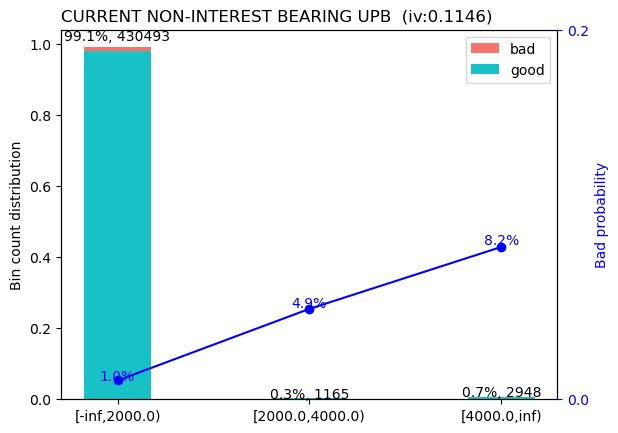

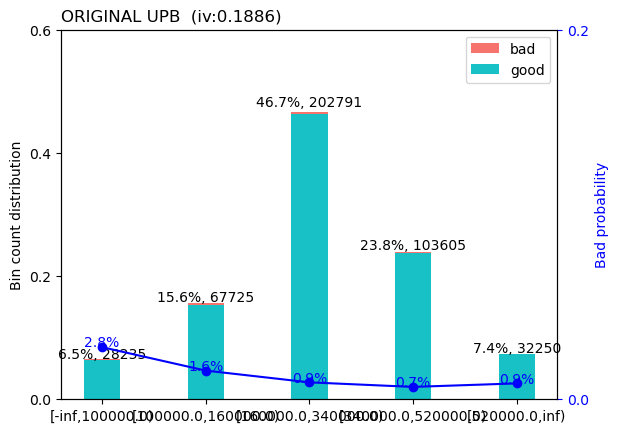

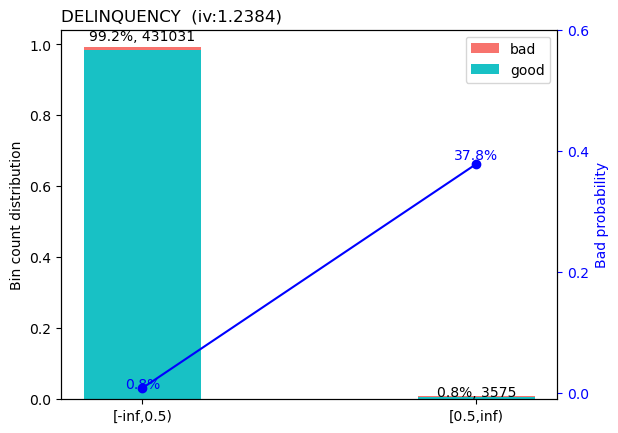

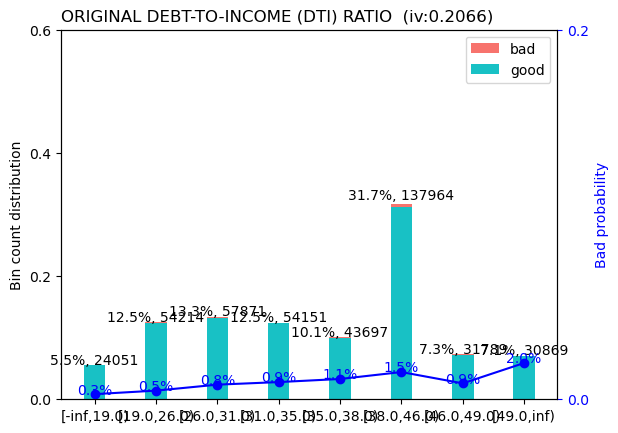

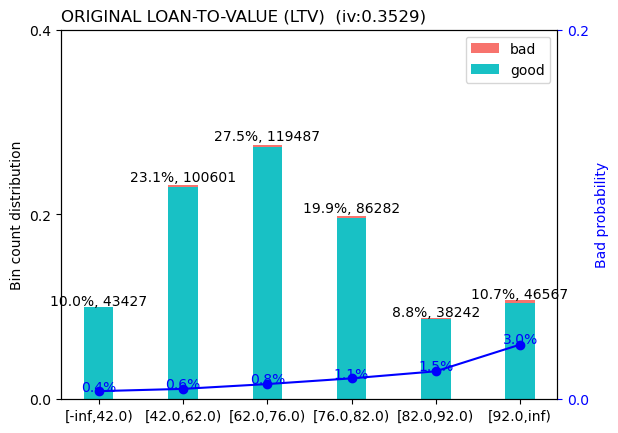

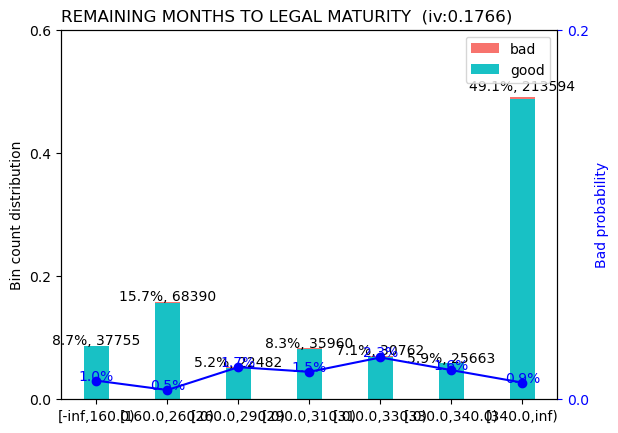

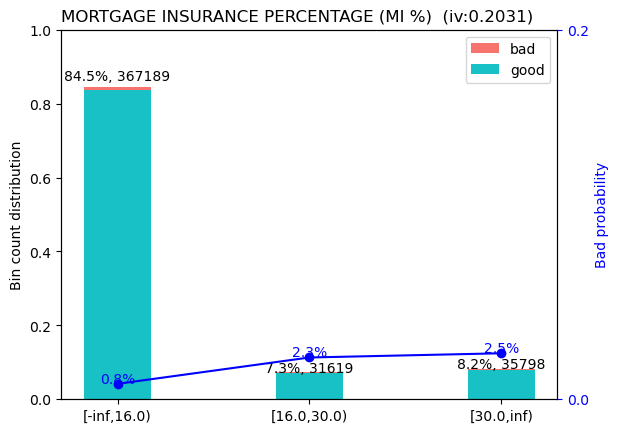

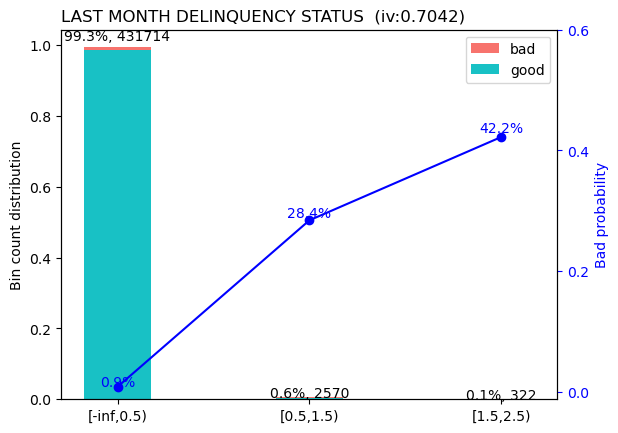

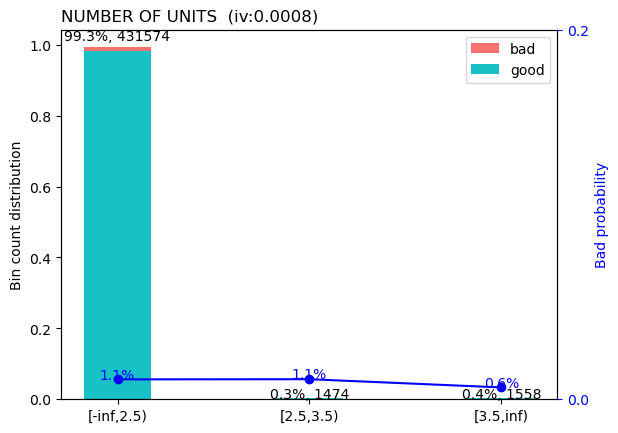

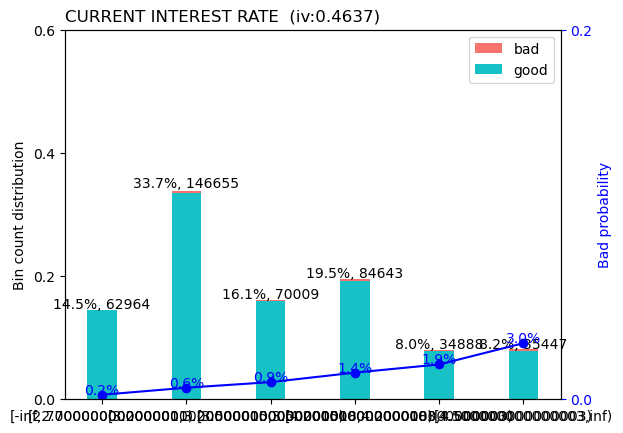

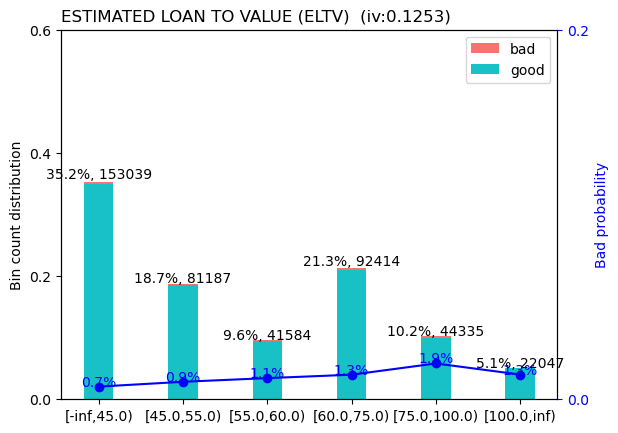

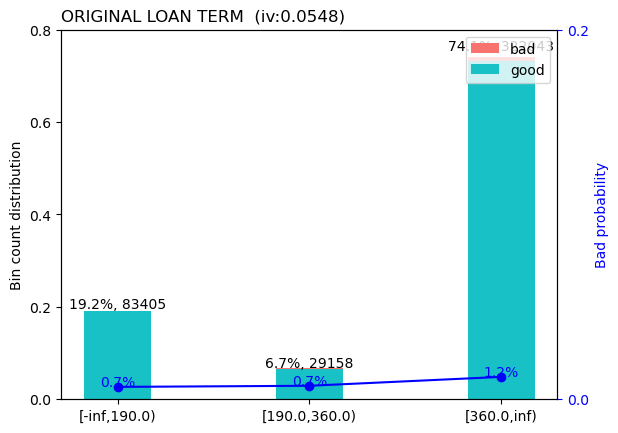

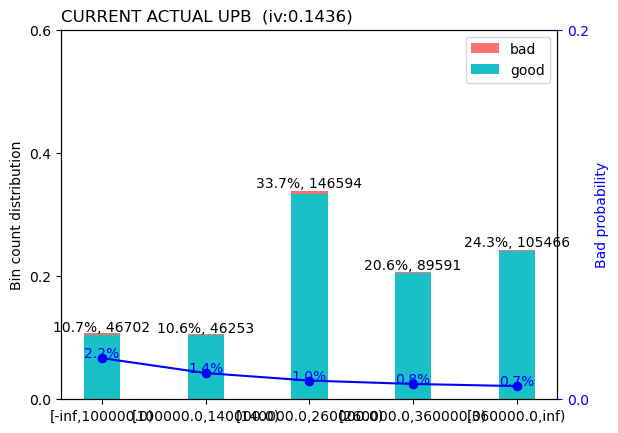

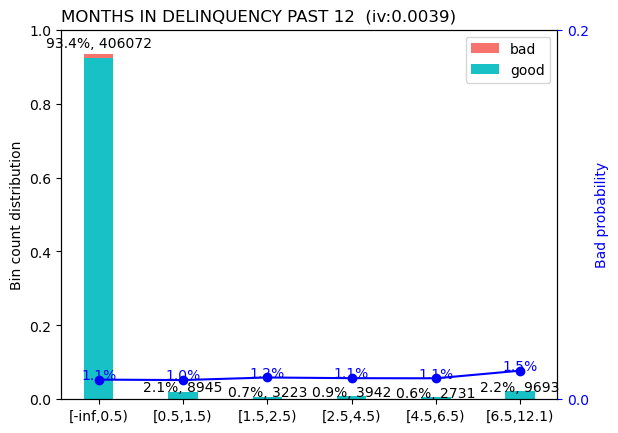

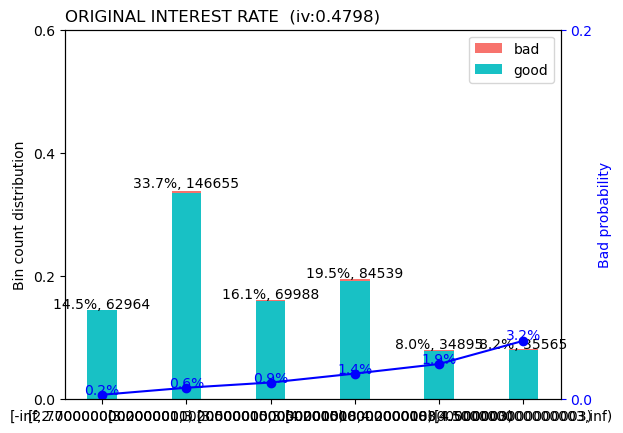

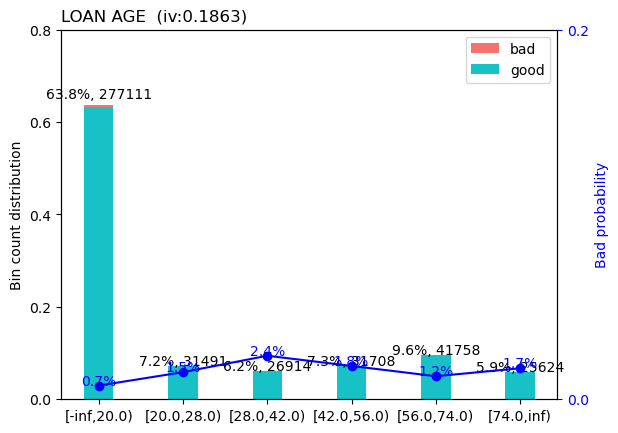

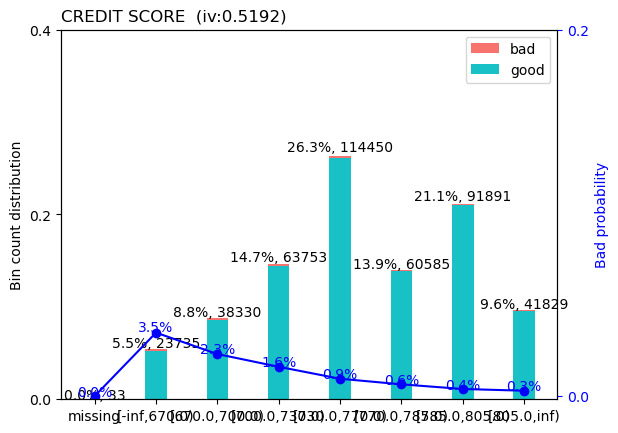

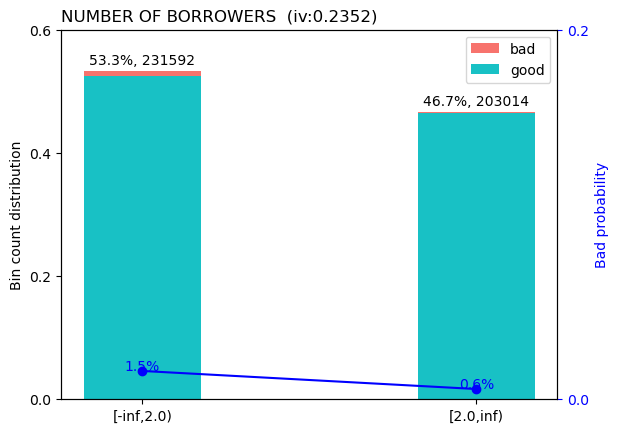

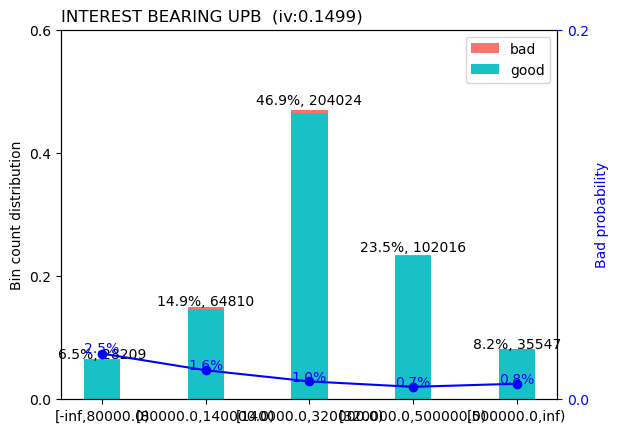

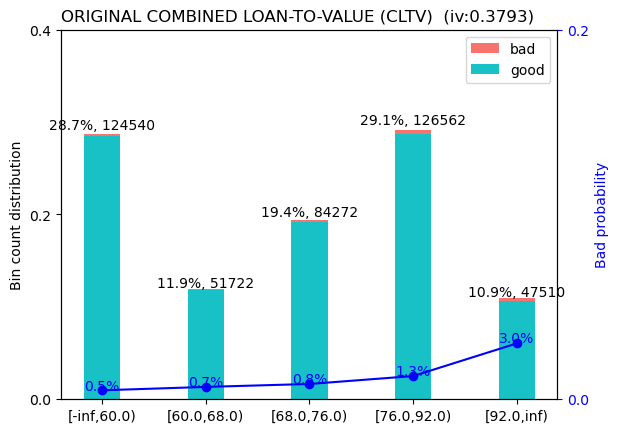

{'CURRENT NON-INTEREST BEARING UPB':                            variable              bin   count  count_distr  \
 0  CURRENT NON-INTEREST BEARING UPB    [-inf,2000.0)  430493     0.990536   
 1  CURRENT NON-INTEREST BEARING UPB  [2000.0,4000.0)    1165     0.002681   
 2  CURRENT NON-INTEREST BEARING UPB     [4000.0,inf)    2948     0.006783   
 
      good   bad   badprob       woe    bin_iv  total_iv  breaks  \
 0  426118  4375  0.010163 -0.057414  0.003175  0.114591  2000.0   
 1    1108    57  0.048927  1.554135  0.014944  0.114591  4000.0   
 2    2705   243  0.082429  2.111600  0.096472  0.114591     inf   
 
    is_special_values  
 0              False  
 1              False  
 2              False  ,
 'ORIGINAL UPB':        variable                  bin   count  count_distr    good   bad  \
 0  ORIGINAL UPB      [-inf,100000.0)   28235     0.064967   27439   796   
 1  ORIGINAL UPB  [100000.0,160000.0)   67725     0.155831   66674  1051   
 2  ORIGINAL UPB  [160000.0,340000.

In [12]:
sc.woebin_plot(bins)
plt.show()

bins

-------- 1/20 CURRENT NON-INTEREST BEARING UPB --------
>>> dt[CURRENT NON-INTEREST BEARING UPB].describe(): 
count    434606.000000
mean         74.390752
std         999.045622
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      122099.260000
Name: CURRENT NON-INTEREST BEARING UPB, dtype: float64 



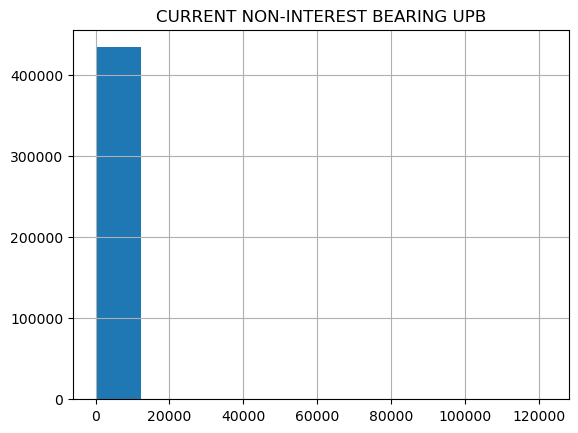

>>> Current breaks:
2000.0,4000.0 



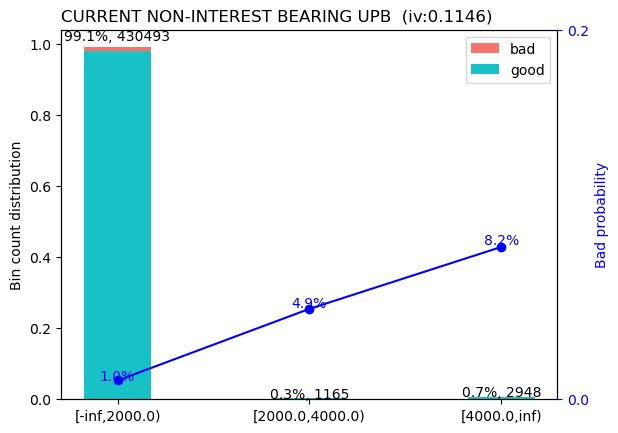

>>> Adjust breaks for (1/20) CURRENT NON-INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 2/20 ORIGINAL UPB --------
>>> dt[ORIGINAL UPB].describe(): 
count    4.346060e+05
mean     2.849065e+05
std      1.522864e+05
min      1.300000e+04
25%      1.700000e+05
50%      2.560000e+05
75%      3.720000e+05
max      1.344000e+06
Name: ORIGINAL UPB, dtype: float64 



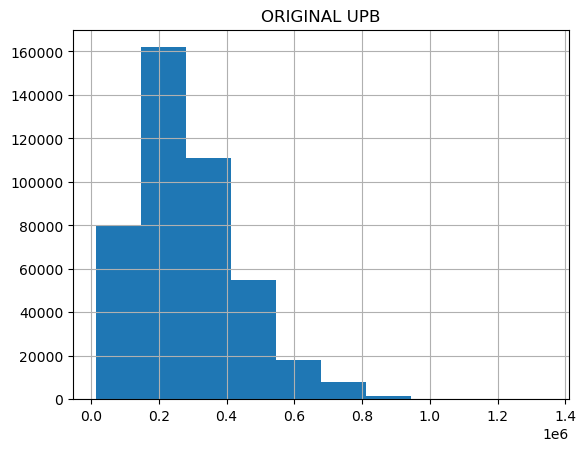

>>> Current breaks:
100000.0,160000.0,340000.0,520000.0 



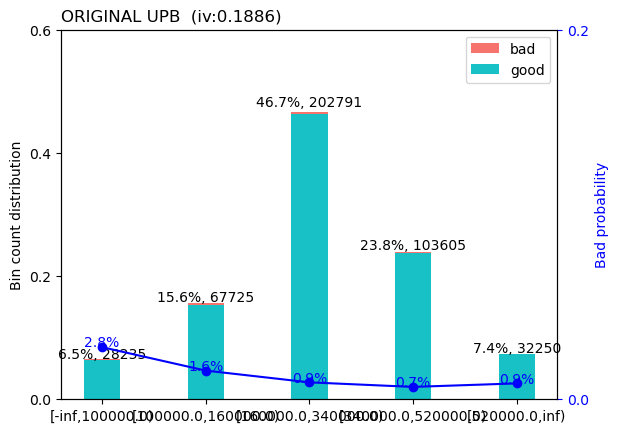

>>> Adjust breaks for (2/20) ORIGINAL UPB?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  2


[INFO] creating woe binning ...
>>> Current breaks:
 



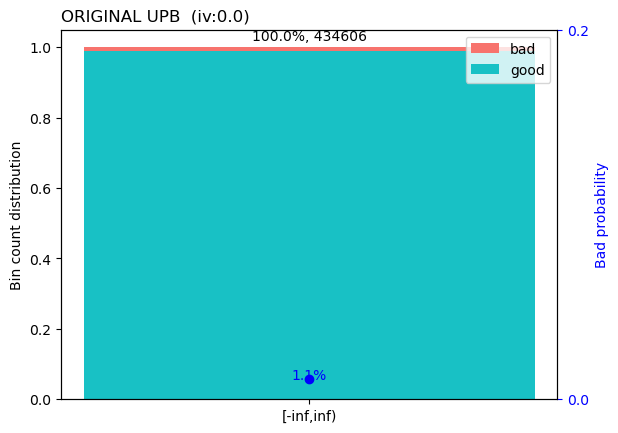

>>> Adjust breaks for (2/20) ORIGINAL UPB?
1: next 
2: yes 
3: back


Selection:  3


-------- 1/20 CURRENT NON-INTEREST BEARING UPB --------
>>> dt[CURRENT NON-INTEREST BEARING UPB].describe(): 
count    434606.000000
mean         74.390752
std         999.045622
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      122099.260000
Name: CURRENT NON-INTEREST BEARING UPB, dtype: float64 



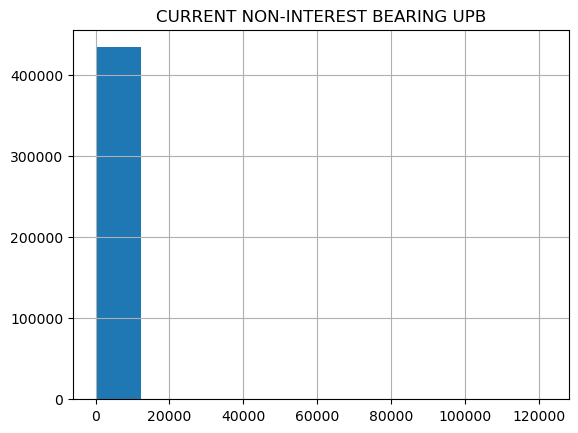

>>> Current breaks:
2000.0,4000.0 



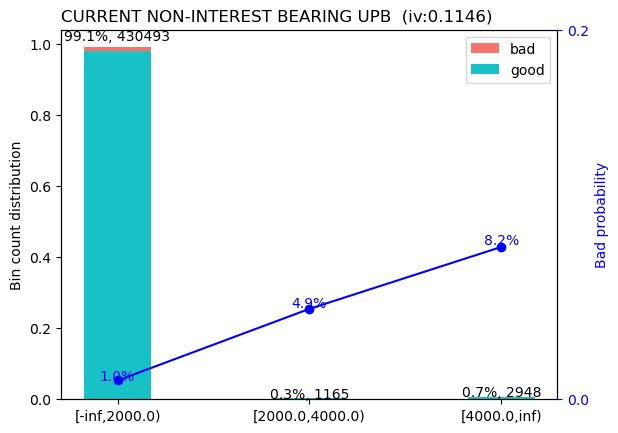

>>> Adjust breaks for (1/20) CURRENT NON-INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 2/20 ORIGINAL UPB --------
>>> dt[ORIGINAL UPB].describe(): 
count    4.346060e+05
mean     2.849065e+05
std      1.522864e+05
min      1.300000e+04
25%      1.700000e+05
50%      2.560000e+05
75%      3.720000e+05
max      1.344000e+06
Name: ORIGINAL UPB, dtype: float64 



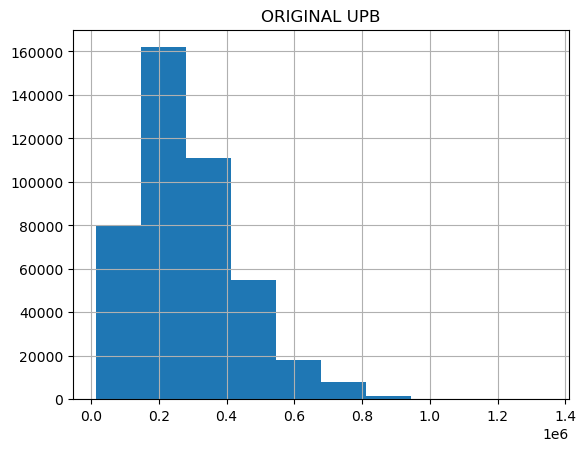

>>> Current breaks:
100000.0,160000.0,340000.0,520000.0 



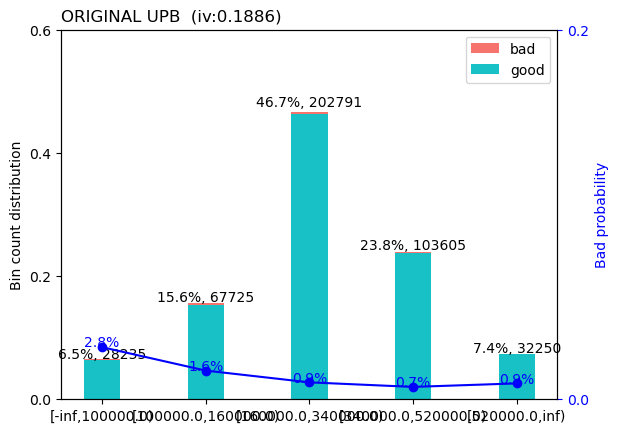

>>> Adjust breaks for (2/20) ORIGINAL UPB?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  100000.0,160000.0,340000.0


[INFO] creating woe binning ...
>>> Current breaks:
100000.0, 160000.0, 340000.0 



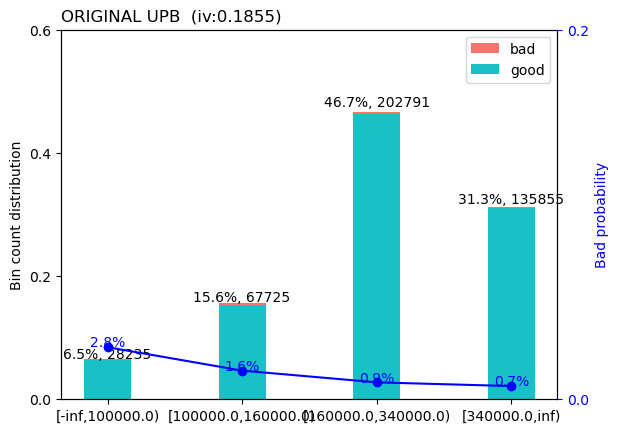

>>> Adjust breaks for (2/20) ORIGINAL UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 3/20 DELINQUENCY --------
>>> dt[DELINQUENCY].describe(): 
count    434606.000000
mean          0.008226
std           0.090323
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: DELINQUENCY, dtype: float64 

>>> dt[DELINQUENCY].value_counts(): 
DELINQUENCY
0    431031
1      3575
Name: count, dtype: int64 

>>> Current breaks:
0.5 



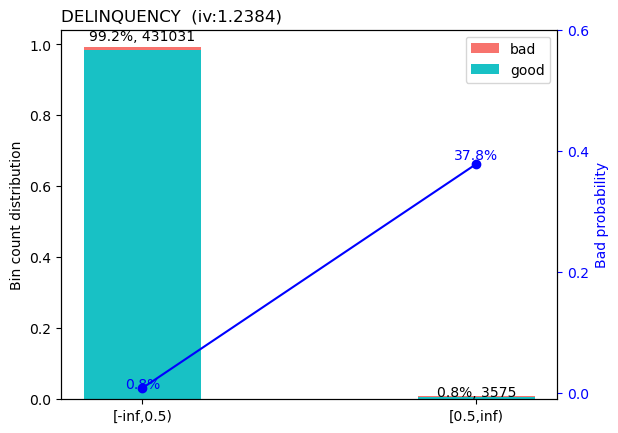

>>> Adjust breaks for (3/20) DELINQUENCY?
1: next 
2: yes 
3: back


Selection:  1


-------- 4/20 ORIGINAL DEBT-TO-INCOME (DTI) RATIO --------
>>> dt[ORIGINAL DEBT-TO-INCOME (DTI) RATIO].describe(): 
count    434606.000000
mean         54.696817
std         137.001570
min           1.000000
25%          28.000000
50%          36.000000
75%          43.000000
max         999.000000
Name: ORIGINAL DEBT-TO-INCOME (DTI) RATIO, dtype: float64 



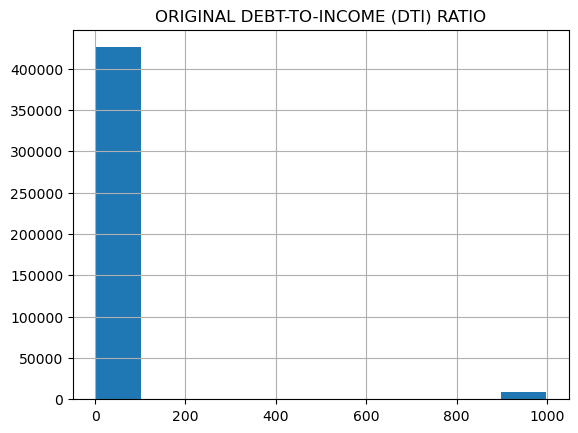

>>> Current breaks:
19.0,26.0,31.0,35.0,38.0,46.0,49.0 



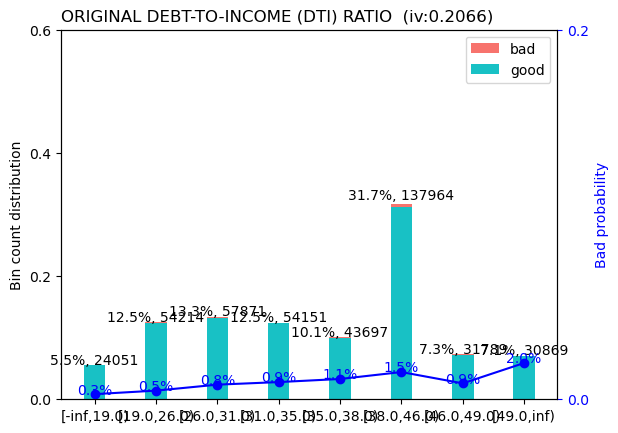

>>> Adjust breaks for (4/20) ORIGINAL DEBT-TO-INCOME (DTI) RATIO?
1: next 
2: yes 
3: back


Selection:  19.0,26.0,31.0,35.0,38.0,42


Input could not be converted to digit.


Selection:  2
>>> Enter modified breaks:  19.0,26.0,31.0,35.0,38.0,42


[INFO] creating woe binning ...
>>> Current breaks:
42.0, 26.0, 19.0, 38.0, 35.0, 31.0 



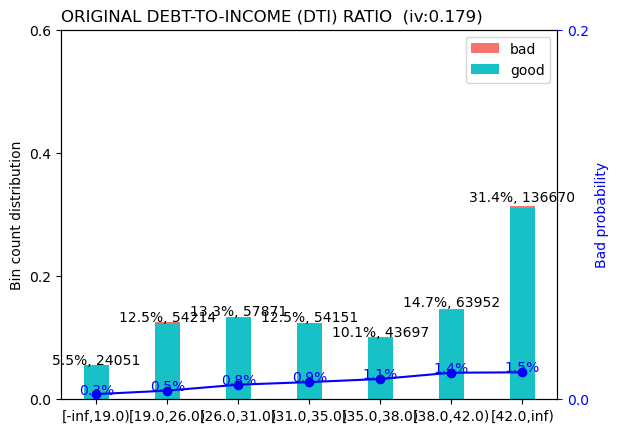

>>> Adjust breaks for (4/20) ORIGINAL DEBT-TO-INCOME (DTI) RATIO?
1: next 
2: yes 
3: back


Selection:  1


-------- 5/20 ORIGINAL LOAN-TO-VALUE (LTV) --------
>>> dt[ORIGINAL LOAN-TO-VALUE (LTV)].describe(): 
count    434606.000000
mean         68.412940
std          18.872357
min           3.000000
25%          57.000000
50%          72.000000
75%          80.000000
max         283.000000
Name: ORIGINAL LOAN-TO-VALUE (LTV), dtype: float64 



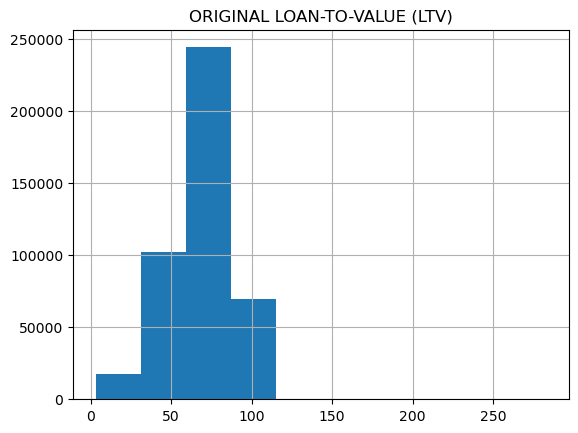

>>> Current breaks:
42.0,62.0,76.0,82.0,92.0 



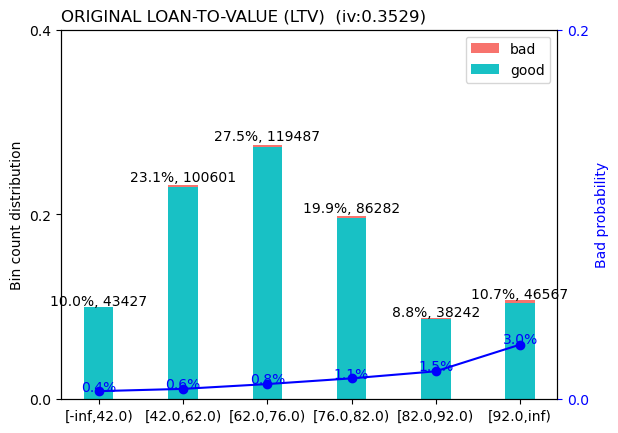

>>> Adjust breaks for (5/20) ORIGINAL LOAN-TO-VALUE (LTV)?
1: next 
2: yes 
3: back


Selection:  1


-------- 6/20 REMAINING MONTHS TO LEGAL MATURITY --------
>>> dt[REMAINING MONTHS TO LEGAL MATURITY].describe(): 
count    434606.000000
mean        294.359811
std          79.994751
min          23.000000
25%         271.000000
50%         339.000000
75%         352.000000
max         479.000000
Name: REMAINING MONTHS TO LEGAL MATURITY, dtype: float64 



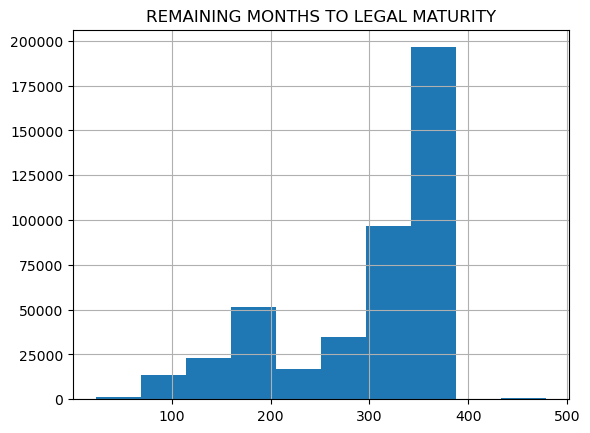

>>> Current breaks:
160.0,260.0,290.0,310.0,330.0,340.0 



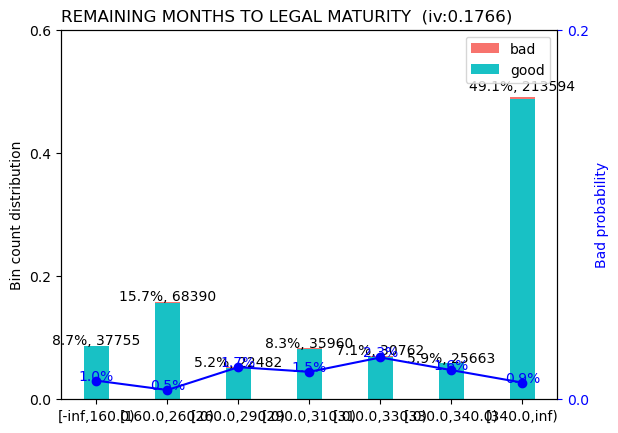

>>> Adjust breaks for (6/20) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  260.0,290.0,330.0,340.0 


[INFO] creating woe binning ...
>>> Current breaks:
260.0, 290.0, 330.0, 340.0 



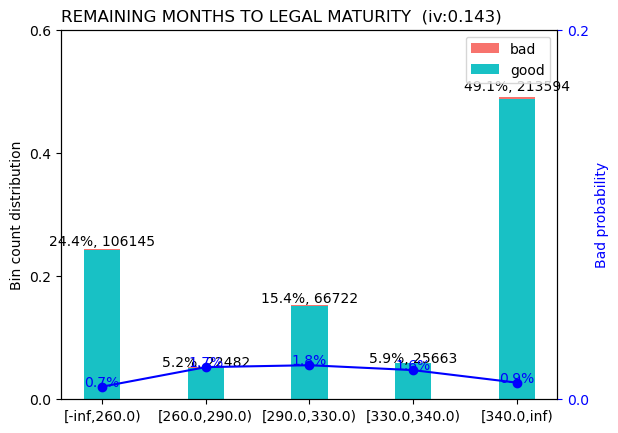

>>> Adjust breaks for (6/20) REMAINING MONTHS TO LEGAL MATURITY?
1: next 
2: yes 
3: back


Selection:  1


-------- 7/20 MORTGAGE INSURANCE PERCENTAGE (MI %) --------
>>> dt[MORTGAGE INSURANCE PERCENTAGE (MI %)].describe(): 
count    434606.000000
mean          4.694245
std          10.118310
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: MORTGAGE INSURANCE PERCENTAGE (MI %), dtype: float64 



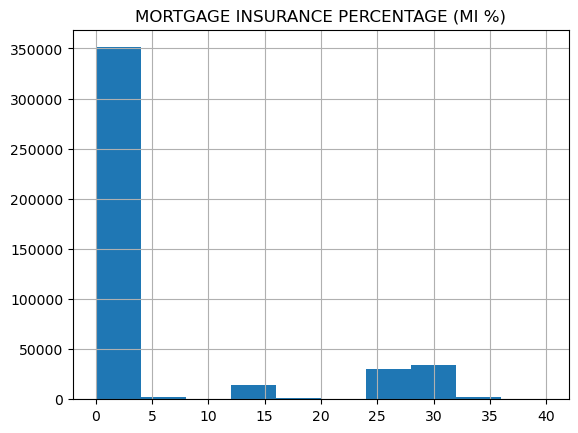

>>> Current breaks:
16.0,30.0 



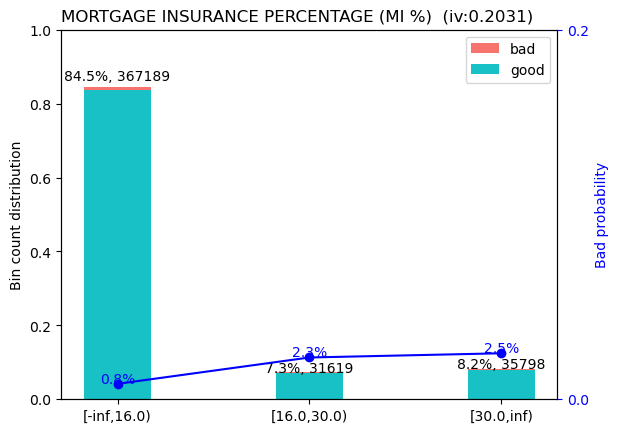

>>> Adjust breaks for (7/20) MORTGAGE INSURANCE PERCENTAGE (MI %)?
1: next 
2: yes 
3: back


Selection:  1


-------- 8/20 LAST MONTH DELINQUENCY STATUS --------
>>> dt[LAST MONTH DELINQUENCY STATUS].describe(): 
count    434606.000000
mean          0.007395
std           0.093927
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: LAST MONTH DELINQUENCY STATUS, dtype: float64 

>>> dt[LAST MONTH DELINQUENCY STATUS].value_counts(): 
LAST MONTH DELINQUENCY STATUS
0.0    431714
1.0      2570
2.0       322
Name: count, dtype: int64 

>>> Current breaks:
0.5,1.5,2.5 



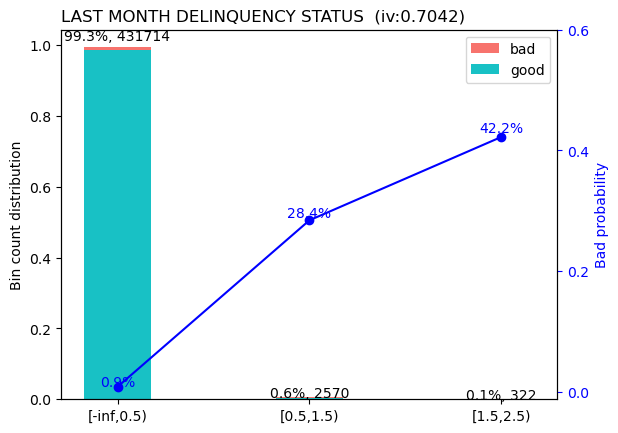

>>> Adjust breaks for (8/20) LAST MONTH DELINQUENCY STATUS?
1: next 
2: yes 
3: back


Selection:  1


-------- 9/20 NUMBER OF UNITS --------
>>> dt[NUMBER OF UNITS].describe(): 
count    434606.000000
mean          1.030791
std           0.241113
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: NUMBER OF UNITS, dtype: float64 

>>> dt[NUMBER OF UNITS].value_counts(): 
NUMBER OF UNITS
1    425814
2      5760
4      1558
3      1474
Name: count, dtype: int64 

>>> Current breaks:
2.5,3.5 



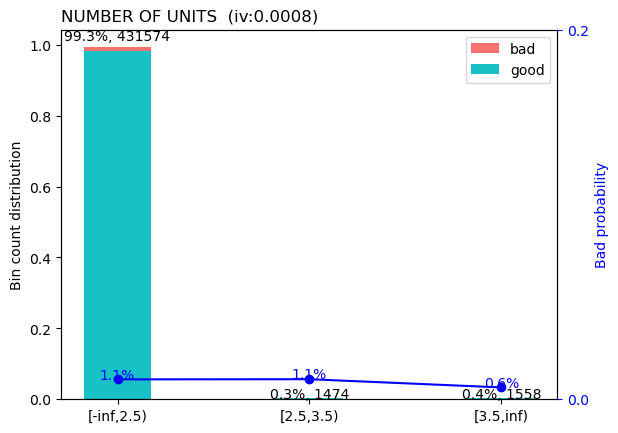

>>> Adjust breaks for (9/20) NUMBER OF UNITS?
1: next 
2: yes 
3: back


Selection:  1


-------- 10/20 CURRENT INTEREST RATE --------
>>> dt[CURRENT INTEREST RATE].describe(): 
count    434606.000000
mean          3.388141
std           0.737358
min           1.750000
25%           2.875000
50%           3.250000
75%           3.875000
max           6.750000
Name: CURRENT INTEREST RATE, dtype: float64 



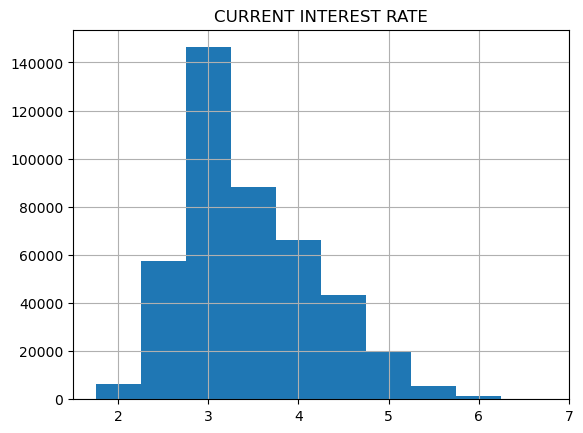

>>> Current breaks:
2.700000000000001,3.2000000000000015,3.5000000000000018,4.200000000000003,4.500000000000003 



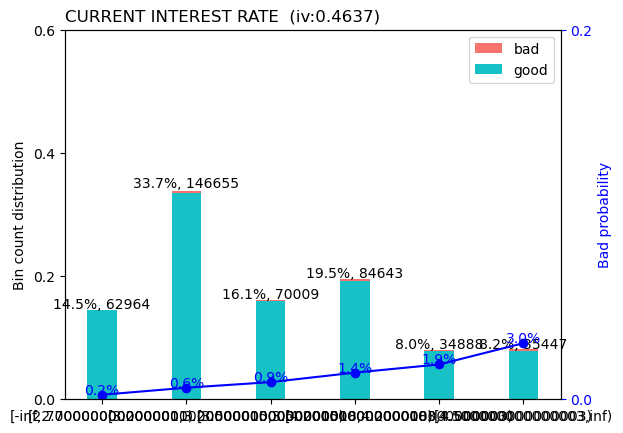

>>> Adjust breaks for (10/20) CURRENT INTEREST RATE?
1: next 
2: yes 
3: back


Selection:  1


-------- 11/20 ESTIMATED LOAN TO VALUE (ELTV) --------
>>> dt[ESTIMATED LOAN TO VALUE (ELTV)].describe(): 
count    434606.000000
mean         97.356353
std         205.541602
min           1.000000
25%          38.000000
50%          53.000000
75%          67.000000
max         999.000000
Name: ESTIMATED LOAN TO VALUE (ELTV), dtype: float64 



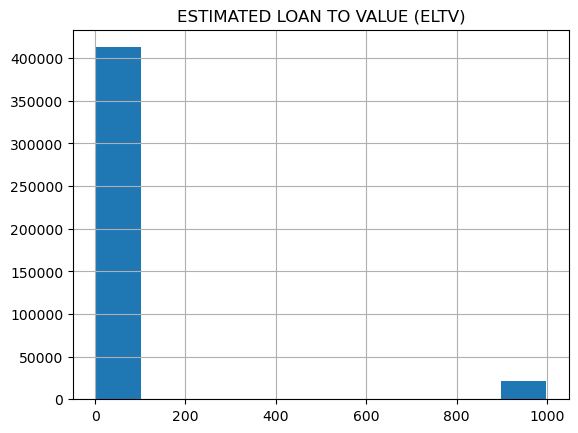

>>> Current breaks:
45.0,55.0,60.0,75.0,100.0 



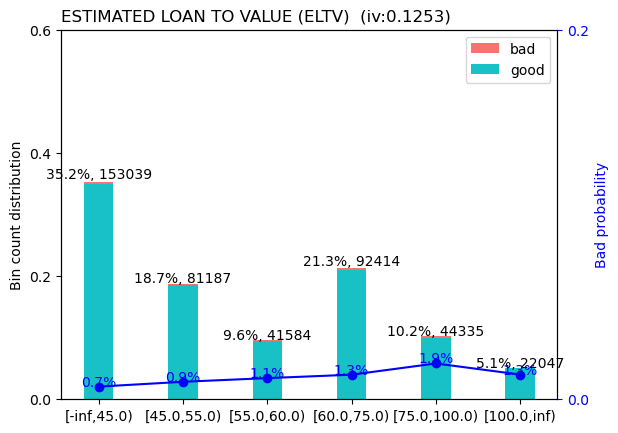

>>> Adjust breaks for (11/20) ESTIMATED LOAN TO VALUE (ELTV)?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  45.0,55.0,60.0,75.0


[INFO] creating woe binning ...
>>> Current breaks:
75.0, 60.0, 45.0, 55.0 



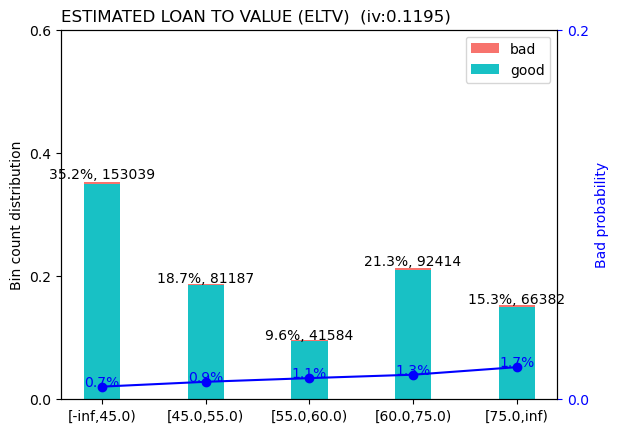

>>> Adjust breaks for (11/20) ESTIMATED LOAN TO VALUE (ELTV)?
1: next 
2: yes 
3: back


Selection:  1


-------- 12/20 ORIGINAL LOAN TERM --------
>>> dt[ORIGINAL LOAN TERM].describe(): 
count    434606.000000
mean        317.889539
std          74.169600
min          96.000000
25%         300.000000
50%         360.000000
75%         360.000000
max         501.000000
Name: ORIGINAL LOAN TERM, dtype: float64 



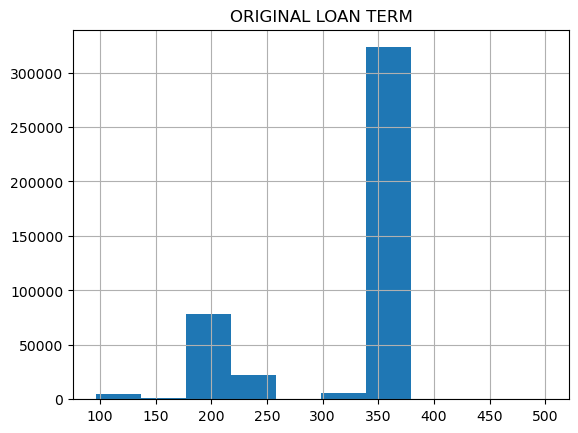

>>> Current breaks:
190.0,360.0 



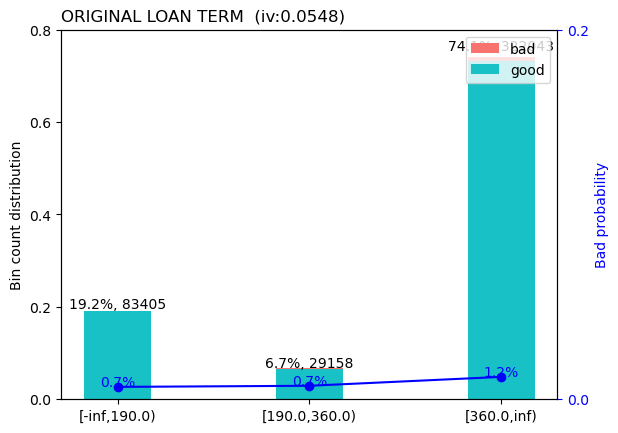

>>> Adjust breaks for (12/20) ORIGINAL LOAN TERM?
1: next 
2: yes 
3: back


Selection:  1


-------- 13/20 CURRENT ACTUAL UPB --------
>>> dt[CURRENT ACTUAL UPB].describe(): 
count    4.346060e+05
mean     2.683163e+05
std      1.532844e+05
min      2.200000e-01
25%      1.520000e+05
50%      2.398495e+05
75%      3.559126e+05
max      1.337000e+06
Name: CURRENT ACTUAL UPB, dtype: float64 



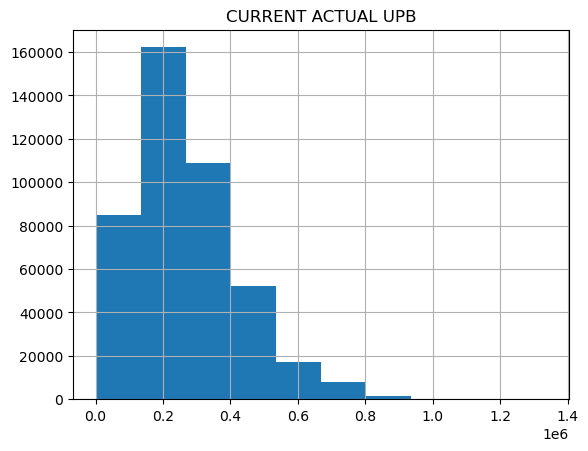

>>> Current breaks:
100000.0,140000.0,260000.0,360000.0 



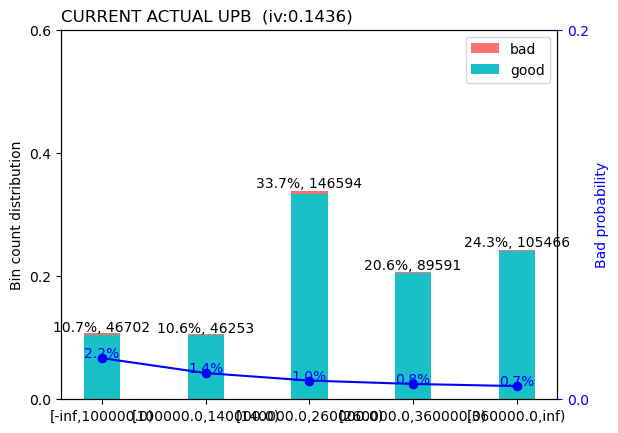

>>> Adjust breaks for (13/20) CURRENT ACTUAL UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 14/20 MONTHS IN DELINQUENCY PAST 12 --------
>>> dt[MONTHS IN DELINQUENCY PAST 12].describe(): 
count    434606.000000
mean          0.332773
std           1.651550
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: MONTHS IN DELINQUENCY PAST 12, dtype: float64 



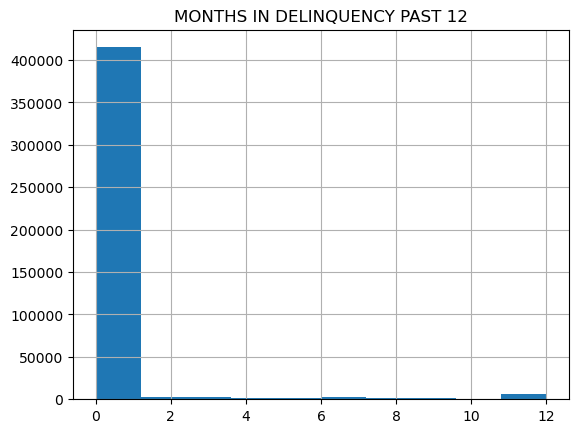

>>> Current breaks:
0.5,1.5,2.5,4.5,6.5,12.1 



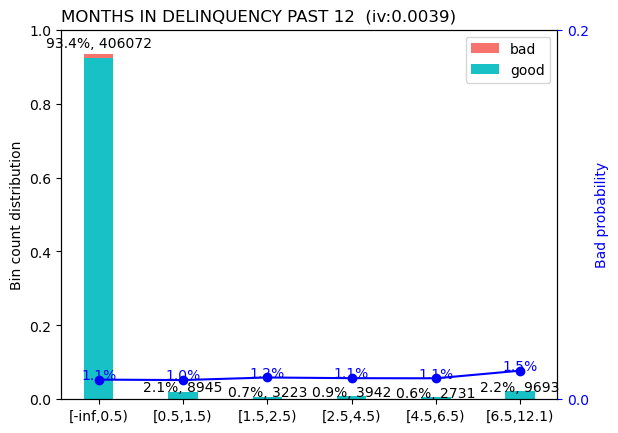

>>> Adjust breaks for (14/20) MONTHS IN DELINQUENCY PAST 12?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  6.5


[INFO] creating woe binning ...
>>> Current breaks:
6.5 



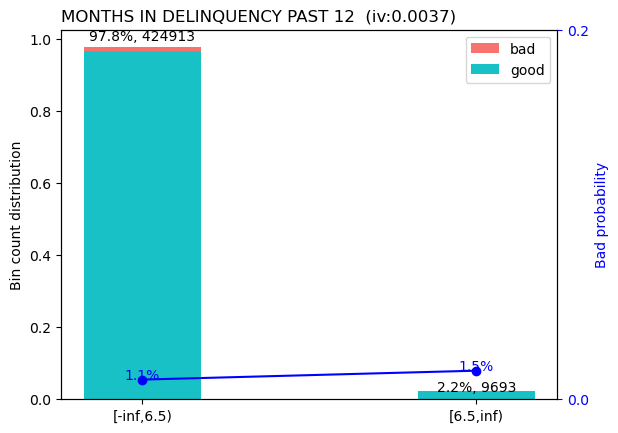

>>> Adjust breaks for (14/20) MONTHS IN DELINQUENCY PAST 12?
1: next 
2: yes 
3: back


Selection:  1


-------- 15/20 ORIGINAL INTEREST RATE --------
>>> dt[ORIGINAL INTEREST RATE].describe(): 
count    434606.000000
mean          3.388492
std           0.737865
min           1.750000
25%           2.875000
50%           3.250000
75%           3.875000
max           6.750000
Name: ORIGINAL INTEREST RATE, dtype: float64 



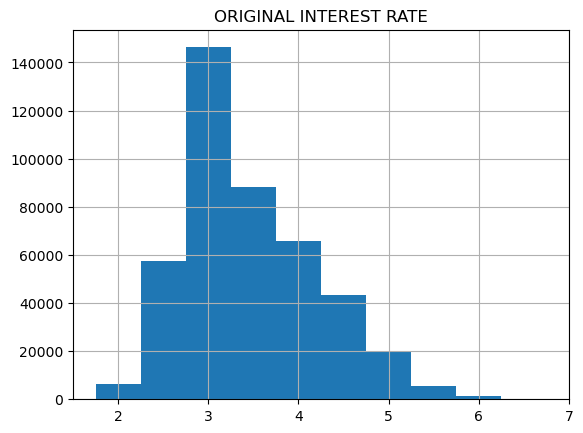

>>> Current breaks:
2.700000000000001,3.2000000000000015,3.5000000000000018,4.200000000000003,4.500000000000003 



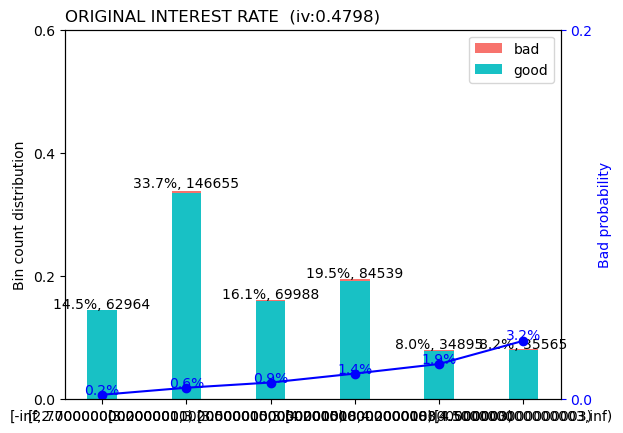

>>> Adjust breaks for (15/20) ORIGINAL INTEREST RATE?
1: next 
2: yes 
3: back


Selection:  1


-------- 16/20 LOAN AGE --------
>>> dt[LOAN AGE].describe(): 
count    434606.000000
mean         23.696965
std          24.139313
min           0.000000
25%           6.000000
50%          13.000000
75%          36.000000
max         100.000000
Name: LOAN AGE, dtype: float64 



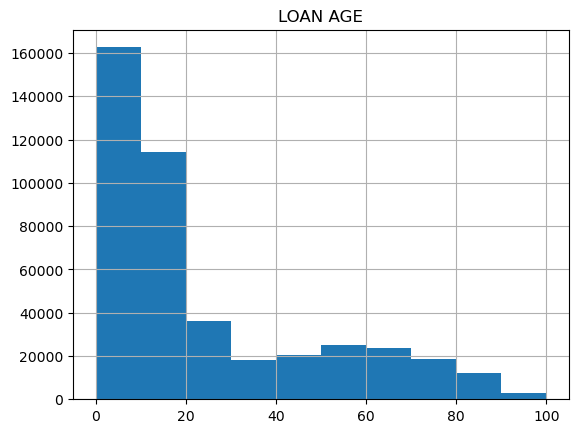

>>> Current breaks:
20.0,28.0,42.0,56.0,74.0 



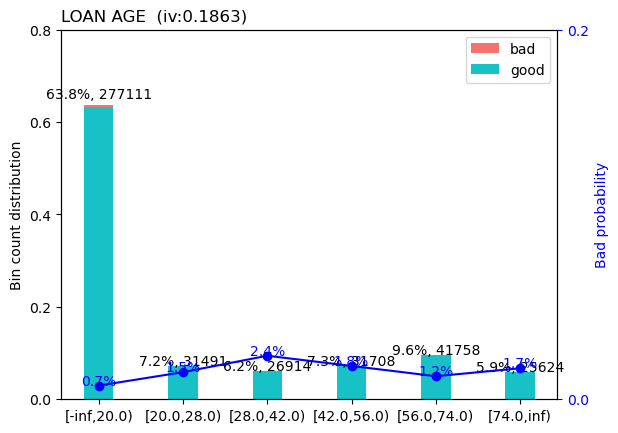

>>> Adjust breaks for (16/20) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  20.0,28.0,42.0,56.0


[INFO] creating woe binning ...
>>> Current breaks:
56.0, 42.0, 28.0, 20.0 



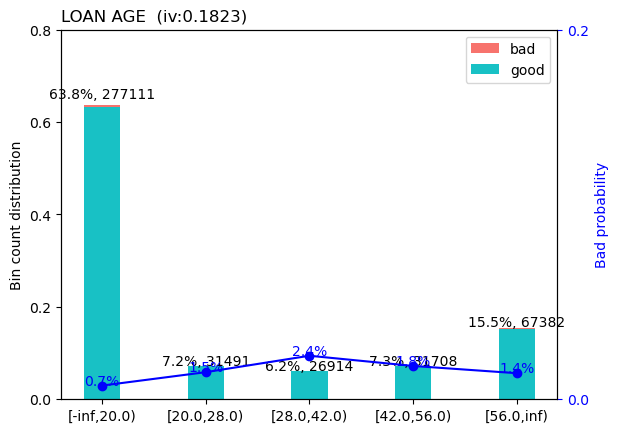

>>> Adjust breaks for (16/20) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  1


[INFO] creating woe binning ...
>>> Current breaks:
1.0 



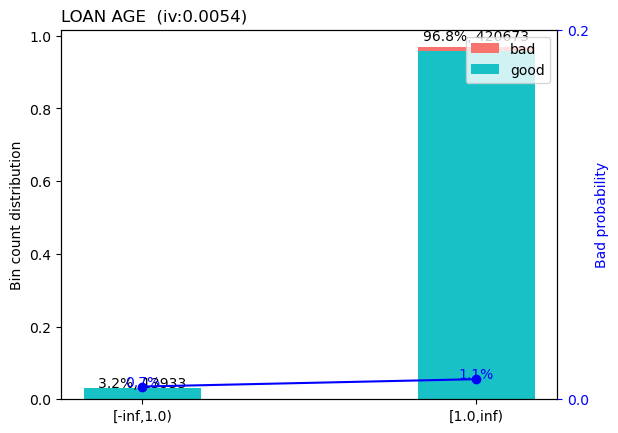

>>> Adjust breaks for (16/20) LOAN AGE?
1: next 
2: yes 
3: back


Selection:  1


-------- 17/20 CREDIT SCORE --------
>>> dt[CREDIT SCORE].describe(): 
count    434573.00000
mean        753.16174
std          45.41641
min         473.00000
25%         722.00000
50%         763.00000
75%         790.00000
max         839.00000
Name: CREDIT SCORE, dtype: float64 



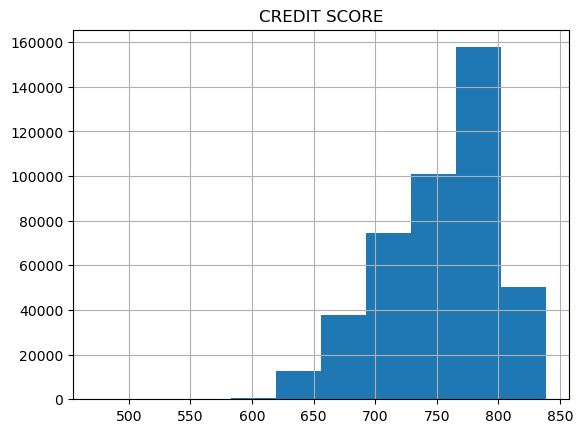

>>> Current breaks:
670.0,700.0,730.0,770.0,785.0,805.0 



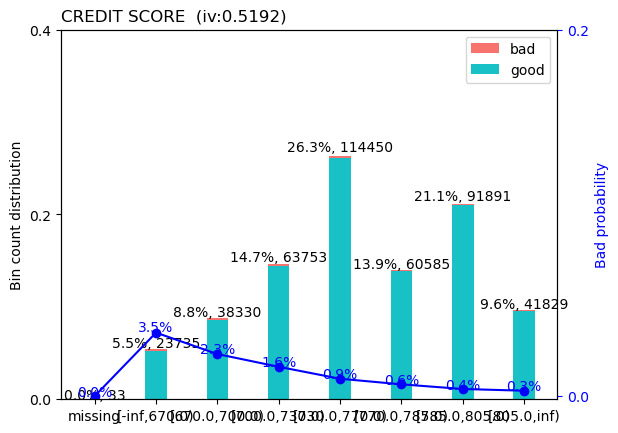

>>> Adjust breaks for (17/20) CREDIT SCORE?
1: next 
2: yes 
3: back


Selection:  1


-------- 18/20 NUMBER OF BORROWERS --------
>>> dt[NUMBER OF BORROWERS].describe(): 
count    434606.000000
mean          1.475203
std           0.517078
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: NUMBER OF BORROWERS, dtype: float64 

>>> dt[NUMBER OF BORROWERS].value_counts(): 
NUMBER OF BORROWERS
1    231592
2    199898
3      2720
4       396
Name: count, dtype: int64 

>>> Current breaks:
2.0 



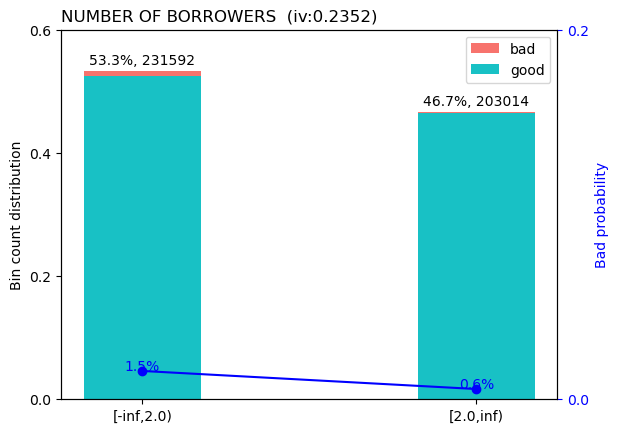

>>> Adjust breaks for (18/20) NUMBER OF BORROWERS?
1: next 
2: yes 
3: back


Selection:  1


-------- 19/20 INTEREST BEARING UPB --------
>>> dt[INTEREST BEARING UPB].describe(): 
count    4.346060e+05
mean     2.682419e+05
std      1.532707e+05
min      1.800000e-01
25%      1.520000e+05
50%      2.397790e+05
75%      3.557791e+05
max      1.337000e+06
Name: INTEREST BEARING UPB, dtype: float64 



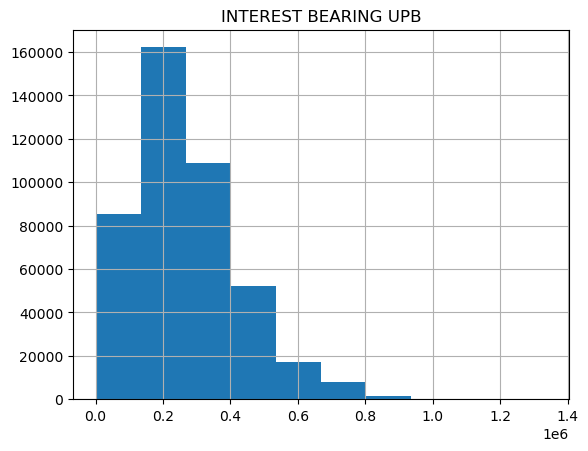

>>> Current breaks:
80000.0,140000.0,320000.0,500000.0 



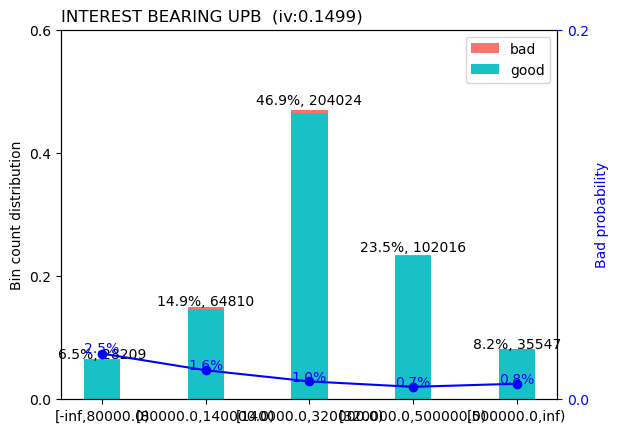

>>> Adjust breaks for (19/20) INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  2
>>> Enter modified breaks:  80000.0,140000.0,320000.0


[INFO] creating woe binning ...
>>> Current breaks:
140000.0, 320000.0, 80000.0 



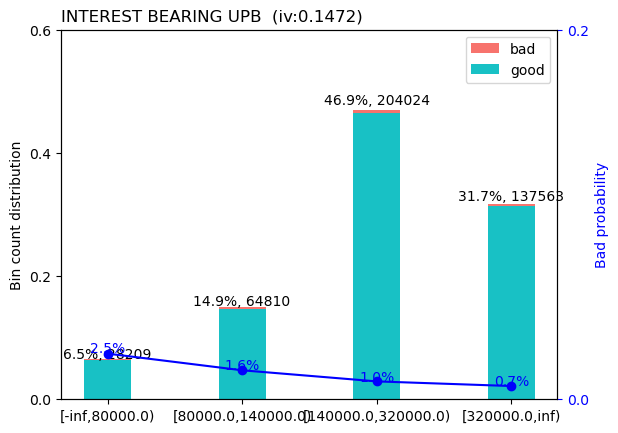

>>> Adjust breaks for (19/20) INTEREST BEARING UPB?
1: next 
2: yes 
3: back


Selection:  1


-------- 20/20 ORIGINAL COMBINED LOAN-TO-VALUE (CLTV) --------
>>> dt[ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)].describe(): 
count    434606.000000
mean         68.722254
std          18.965328
min           3.000000
25%          57.000000
50%          72.000000
75%          80.000000
max         354.000000
Name: ORIGINAL COMBINED LOAN-TO-VALUE (CLTV), dtype: float64 



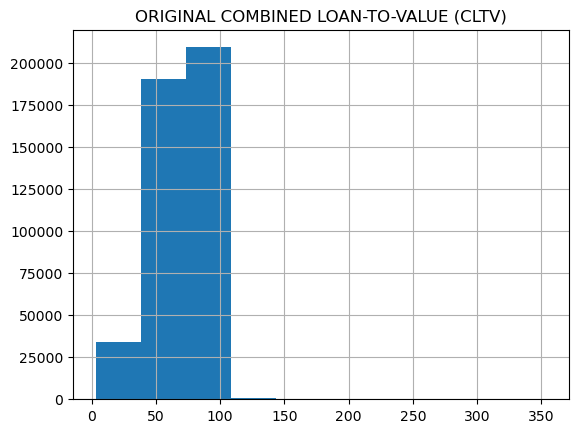

>>> Current breaks:
60.0,68.0,76.0,92.0 



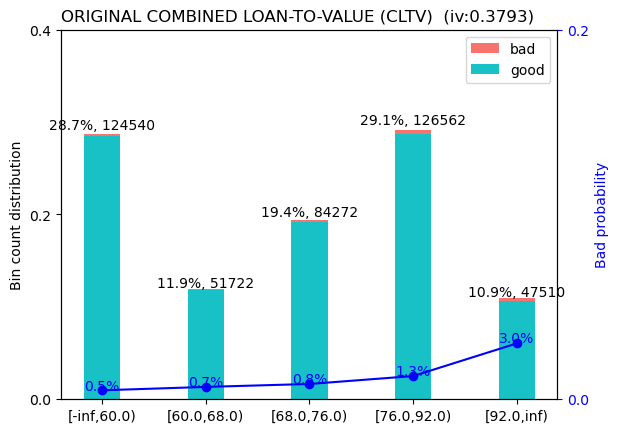

>>> Adjust breaks for (20/20) ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)?
1: next 
2: yes 
3: back


Selection:  1


In [13]:
breaks_adj = sc.woebin_adj(X_train_bin, "DEFAULT_NEXT_12", bins, adj_all_var=True)

In [19]:
bins_adj = sc.woebin(
    X_train_bin,
    y="DEFAULT_NEXT_12",
    breaks_list=breaks_adj 
)

train_woe = sc.woebin_ply(X_train_bin, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(X_test_bin, bins_adj) # Calculate WoE dataset (test)

[INFO] creating woe binning ...


/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .stack().replace('missing', np.nan) \
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/opt/anaconda3/lib/python3.12/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided calla

Binning on 434606 rows and 21 columns in 00:00:13
[INFO] converting into woe values ...
Woe transformating on 434606 rows and 20 columns in 00:00:11
[INFO] converting into woe values ...


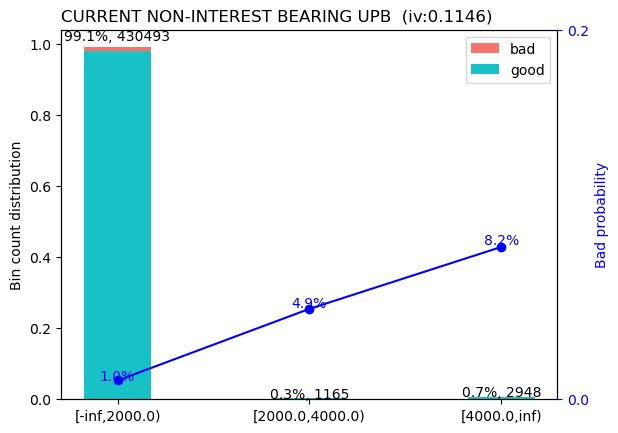

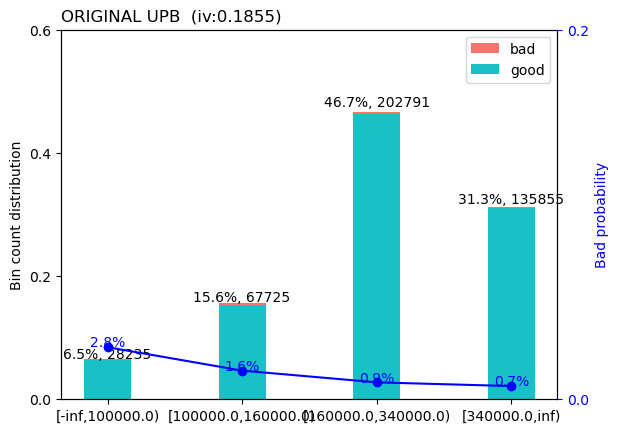

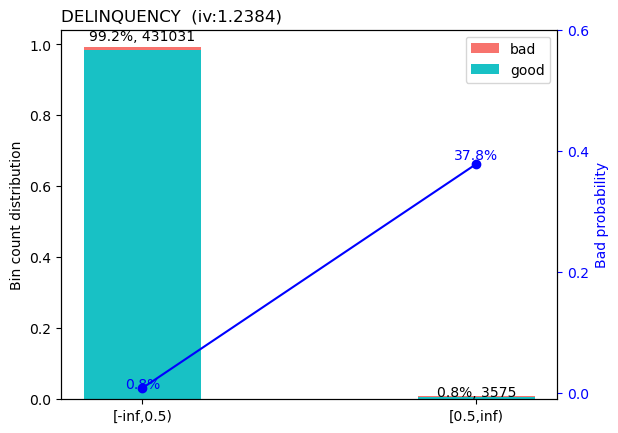

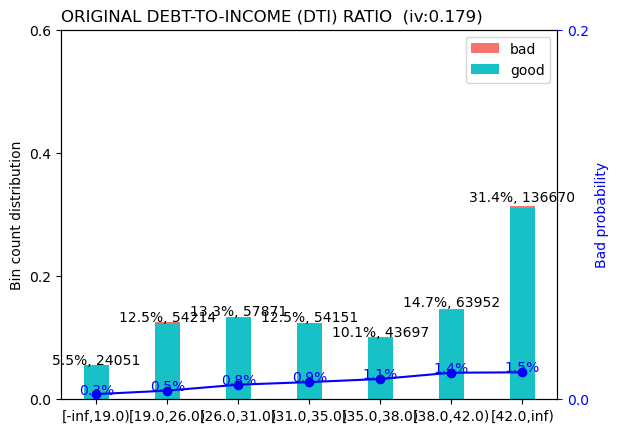

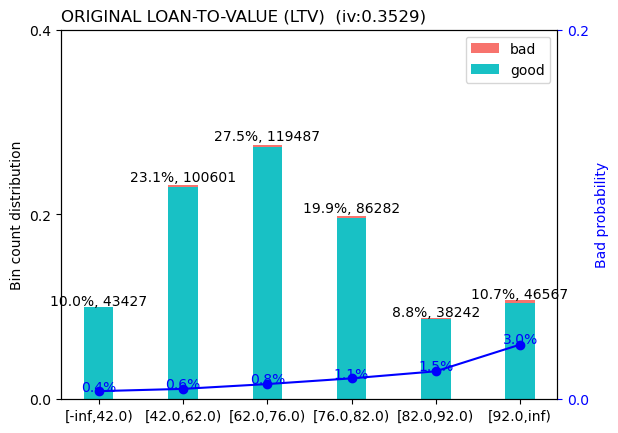

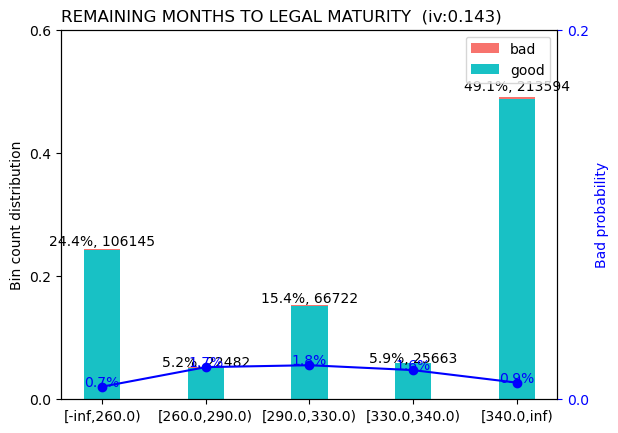

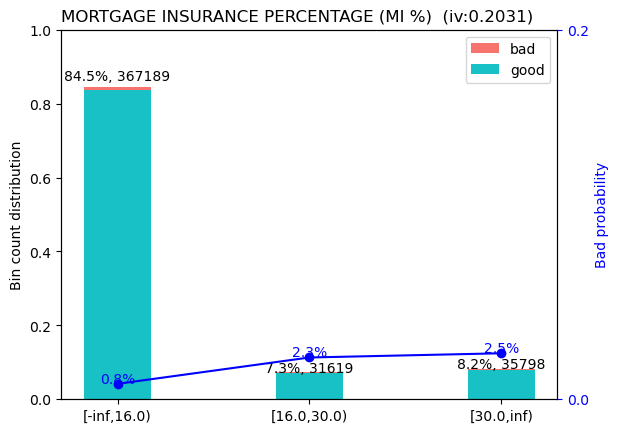

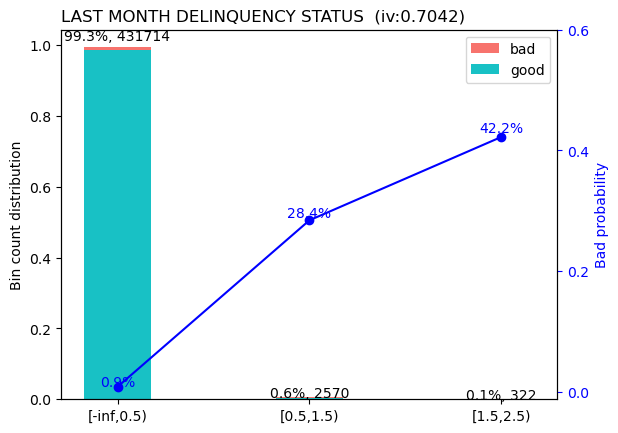

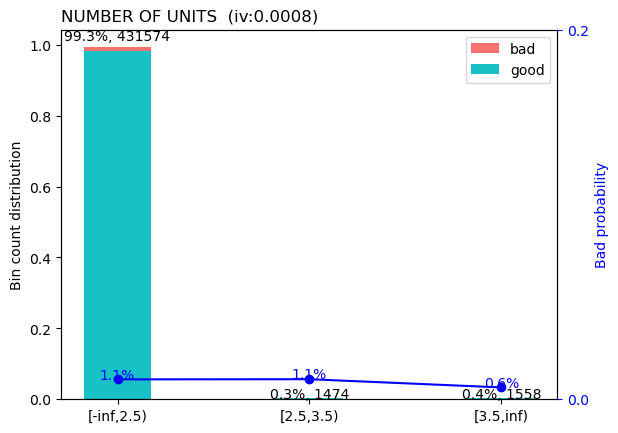

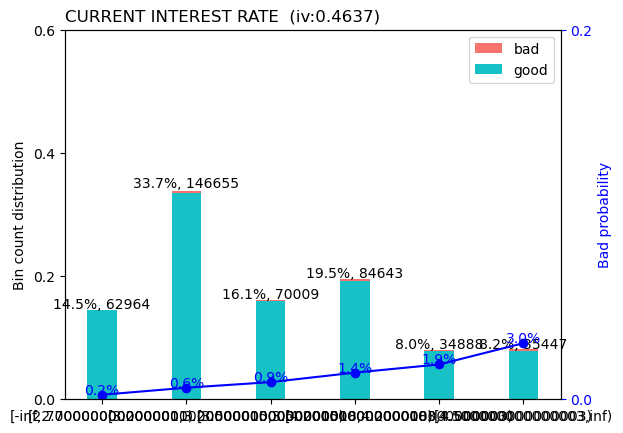

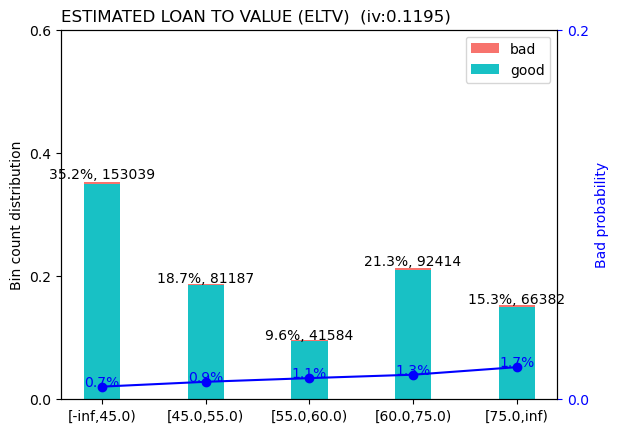

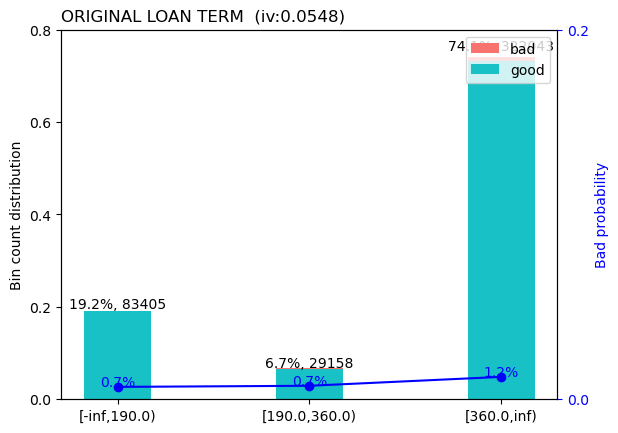

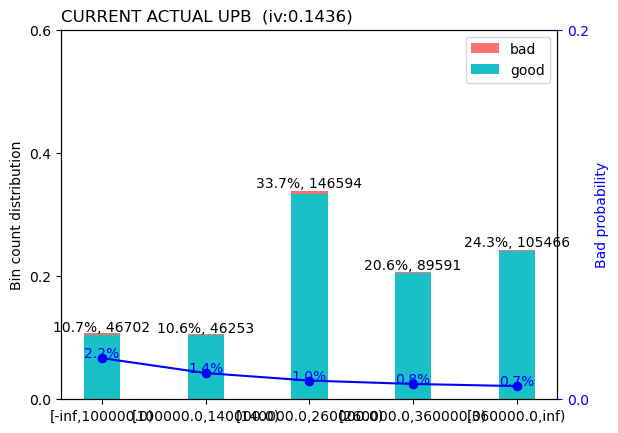

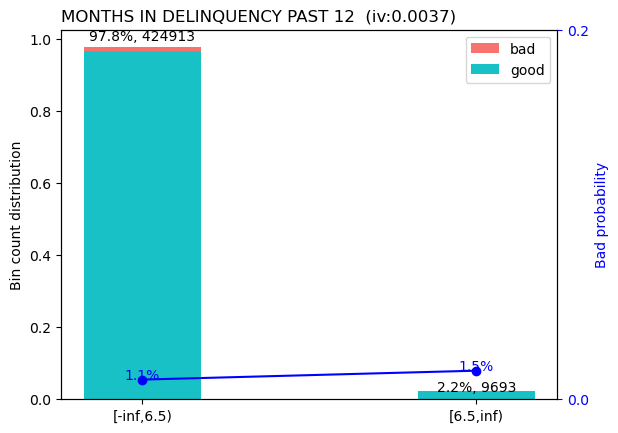

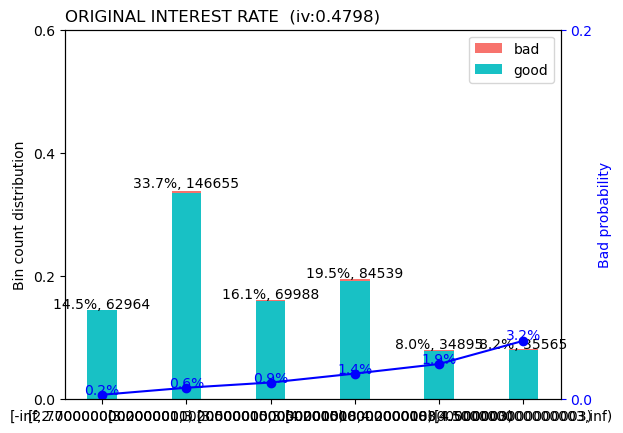

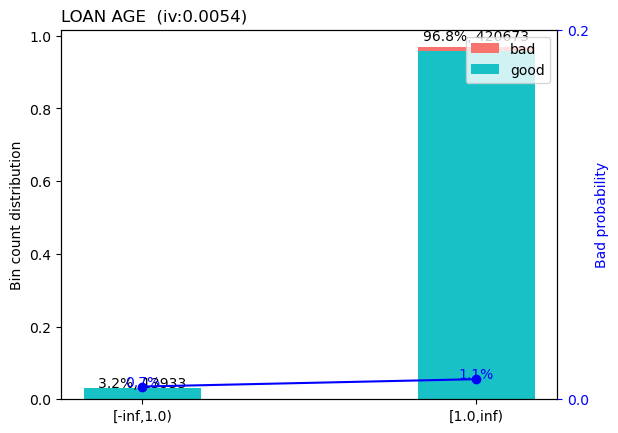

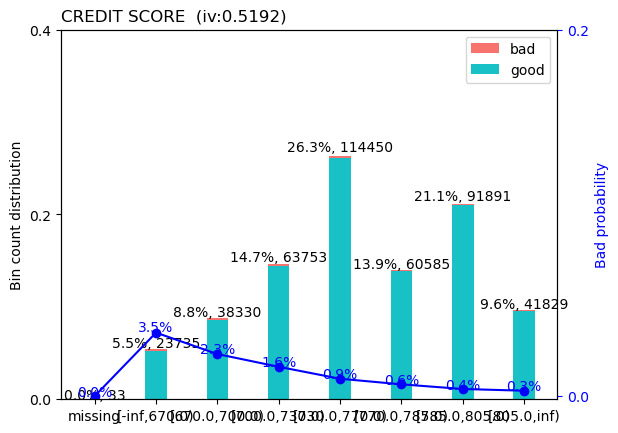

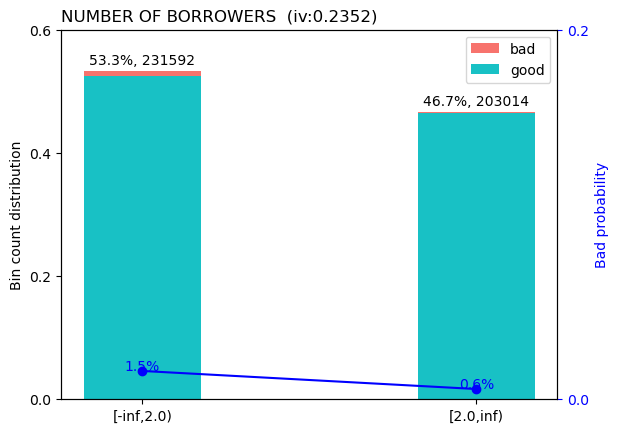

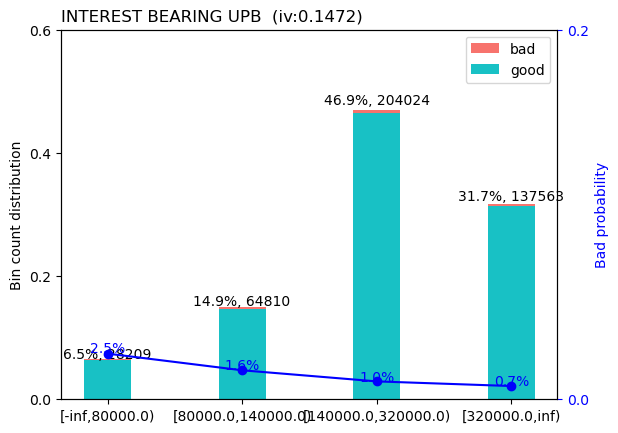

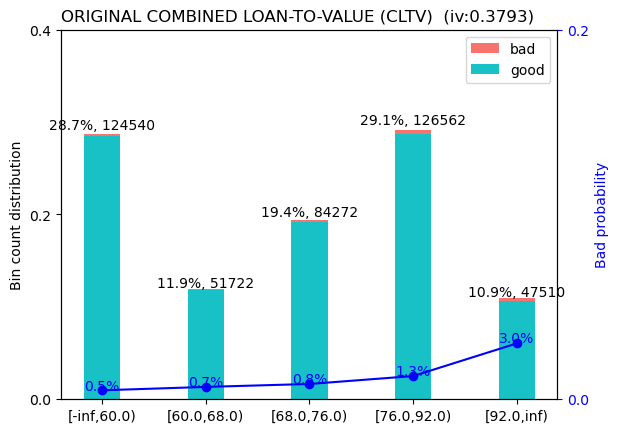

{'CURRENT NON-INTEREST BEARING UPB':                            variable              bin   count  count_distr  \
 0  CURRENT NON-INTEREST BEARING UPB    [-inf,2000.0)  430493     0.990536   
 1  CURRENT NON-INTEREST BEARING UPB  [2000.0,4000.0)    1165     0.002681   
 2  CURRENT NON-INTEREST BEARING UPB     [4000.0,inf)    2948     0.006783   
 
      good   bad   badprob       woe    bin_iv  total_iv  breaks  \
 0  426118  4375  0.010163 -0.057414  0.003175  0.114591  2000.0   
 1    1108    57  0.048927  1.554135  0.014944  0.114591  4000.0   
 2    2705   243  0.082429  2.111600  0.096472  0.114591     inf   
 
    is_special_values  
 0              False  
 1              False  
 2              False  ,
 'ORIGINAL UPB':        variable                  bin   count  count_distr    good   bad  \
 0  ORIGINAL UPB      [-inf,100000.0)   28235     0.064967   27439   796   
 1  ORIGINAL UPB  [100000.0,160000.0)   67725     0.155831   66674  1051   
 2  ORIGINAL UPB  [160000.0,340000.

In [20]:
sc.woebin_plot(bins_adj)
plt.show()

bins_adj

In [23]:
train_woe.head()

,DEFAULT_NEXT_12,DELINQUENCY_woe,ORIGINAL LOAN-TO-VALUE (LTV)_woe,MORTGAGE INSURANCE PERCENTAGE (MI %)_woe,NUMBER OF UNITS_woe,CURRENT INTEREST RATE_woe,CURRENT ACTUAL UPB_woe,MONTHS IN DELINQUENCY PAST 12_woe,ORIGINAL INTEREST RATE_woe,NUMBER OF BORROWERS_woe,...,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)_woe,CURRENT NON-INTEREST BEARING UPB_woe,ORIGINAL UPB_woe,ORIGINAL DEBT-TO-INCOME (DTI) RATIO_woe,REMAINING MONTHS TO LEGAL MATURITY_woe,LAST MONTH DELINQUENCY STATUS_woe,ESTIMATED LOAN TO VALUE (ELTV)_woe,ORIGINAL LOAN TERM_woe,LOAN AGE_woe,CREDIT SCORE_woe
351873,False,-0.336177,1.031175,0.853297,0.001439,1.057433,0.739350,-0.010165,1.100877,0.358813,...,1.053008,-0.057414,0.981274,-1.359054,0.546482,-0.200404,-0.129820,0.120650,0.011965,1.193484
55630,False,-0.336177,0.051894,-0.254736,0.001439,-0.150237,0.279959,-0.010165,-0.171944,-0.668539,...,0.157040,-0.057414,-0.162619,0.021192,-0.459530,-0.200404,-0.455542,-0.477194,0.011965,-0.520579
1457161,False,-0.336177,1.031175,0.853297,0.001439,-0.547063,-0.262591,-0.010165,-0.547063,-0.668539,...,1.053008,-0.057414,-0.412448,-0.309761,-0.178702,-0.200404,0.486741,0.120650,0.011965,-0.128761
339662,False,-0.336177,-0.269672,-0.254736,0.001439,0.569743,0.279959,-0.010165,0.583386,-0.668539,...,-0.263873,-0.057414,0.371323,0.308157,0.546482,-0.200404,-0.129820,0.120650,0.011965,-1.025527
563602,False,-0.336177,0.051894,-0.254736,0.001439,-0.150237,-0.262591,-0.010165,-0.171944,-0.668539,...,0.157040,-0.057414,-0.162619,0.308157,-0.178702,-0.200404,0.062855,0.120650,0.011965,0.402118


In [25]:
test_woe.head()

,DEFAULT_NEXT_12,DELINQUENCY_woe,ORIGINAL LOAN-TO-VALUE (LTV)_woe,MORTGAGE INSURANCE PERCENTAGE (MI %)_woe,NUMBER OF UNITS_woe,CURRENT INTEREST RATE_woe,CURRENT ACTUAL UPB_woe,MONTHS IN DELINQUENCY PAST 12_woe,ORIGINAL INTEREST RATE_woe,NUMBER OF BORROWERS_woe,...,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)_woe,CURRENT NON-INTEREST BEARING UPB_woe,ORIGINAL UPB_woe,ORIGINAL DEBT-TO-INCOME (DTI) RATIO_woe,REMAINING MONTHS TO LEGAL MATURITY_woe,LAST MONTH DELINQUENCY STATUS_woe,ESTIMATED LOAN TO VALUE (ELTV)_woe,ORIGINAL LOAN TERM_woe,LOAN AGE_woe,CREDIT SCORE_woe
719458,False,-0.336177,0.346265,0.755037,0.001439,-1.489521,-0.414856,-0.010165,-1.489521,-0.668539,...,0.157040,-0.057414,-0.412448,-0.837268,-0.178702,-0.200404,0.214706,0.120650,0.011965,-0.128761
1264779,False,-0.336177,1.031175,0.853297,0.001439,-0.547063,-0.061355,-0.010165,-0.547063,0.358813,...,1.053008,-0.057414,-0.162619,0.308157,-0.178702,-0.200404,0.486741,0.120650,0.011965,-1.025527
569653,False,-0.336177,-0.653286,-0.254736,0.001439,-0.547063,-0.262591,-0.010165,-0.547063,0.358813,...,-0.800888,-0.057414,-0.162619,0.308157,0.388384,-0.200404,-0.455542,0.120650,0.011965,0.770363
919804,False,-0.336177,-0.269672,-0.254736,0.001439,-1.489521,-0.414856,-0.010165,-1.489521,-0.668539,...,-0.263873,-0.057414,-0.412448,0.308157,-0.459530,-0.200404,-0.129820,-0.477194,0.011965,-0.128761
459037,False,-0.336177,0.346265,0.755037,0.001439,0.297154,-0.414856,-0.010165,0.260310,-0.668539,...,0.157040,2.111600,-0.412448,0.308157,0.388384,-0.200404,0.214706,0.120650,0.011965,0.402118


In [41]:
train_woe.describe()

,DELINQUENCY_woe,ORIGINAL LOAN-TO-VALUE (LTV)_woe,MORTGAGE INSURANCE PERCENTAGE (MI %)_woe,NUMBER OF UNITS_woe,CURRENT INTEREST RATE_woe,CURRENT ACTUAL UPB_woe,MONTHS IN DELINQUENCY PAST 12_woe,ORIGINAL INTEREST RATE_woe,NUMBER OF BORROWERS_woe,INTEREST BEARING UPB_woe,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)_woe,CURRENT NON-INTEREST BEARING UPB_woe,ORIGINAL UPB_woe,ORIGINAL DEBT-TO-INCOME (DTI) RATIO_woe,REMAINING MONTHS TO LEGAL MATURITY_woe,LAST MONTH DELINQUENCY STATUS_woe,ESTIMATED LOAN TO VALUE (ELTV)_woe,ORIGINAL LOAN TERM_woe,LOAN AGE_woe,CREDIT SCORE_woe
count,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434606.000000,434284.000000,434606.000000,434606.000000,434606.000000,434606.000000
mean,-0.300310,-0.164109,-0.090004,-0.000406,-0.234745,-0.066256,-0.001720,-0.240525,-0.121086,-0.067708,-0.176840,-0.038382,-0.083194,-0.096927,-0.068026,-0.177921,-0.058649,-0.028373,-0.002825,-0.256734
std,0.393834,0.545843,0.384933,0.031213,0.710920,0.346326,0.055912,0.713453,0.512565,0.349443,0.567227,0.196244,0.377674,0.488129,0.360104,0.291399,0.345181,0.252805,0.081265,0.718629
min,-0.336177,-0.900760,-0.254736,-0.520738,-1.489521,-0.414856,-0.010165,-1.489521,-0.668539,-0.409592,-0.800888,-0.057414,-0.412448,-1.359054,-0.459530,-0.200404,-0.455542,-0.477194,-0.449358,-1.305013
25%,-0.336177,-0.653286,-0.254736,0.001439,-0.547063,-0.262591,-0.010165,-0.547063,-0.668539,-0.409592,-0.800888,-0.057414,-0.412448,-0.309761,-0.178702,-0.200404,-0.455542,-0.390465,0.011965,-1.025527
50%,-0.336177,-0.269672,-0.254736,0.001439,-0.150237,-0.061355,-0.010165,-0.171944,0.358813,-0.106546,-0.263873,-0.057414,-0.162619,0.021192,-0.178702,-0.200404,-0.129820,0.120650,0.011965,-0.128761
75%,-0.336177,0.051894,-0.254736,0.001439,0.297154,-0.061355,-0.010165,0.260310,0.358813,-0.106546,0.157040,-0.057414,-0.162619,0.308157,0.388384,-0.200404,0.214706,0.120650,0.011965,0.402118
max,4.024123,1.031175,0.853297,0.009163,1.057433,0.739350,0.368468,1.100877,0.358813,0.845803,1.053008,2.111600,0.981274,0.308157,0.546482,3.598832,0.486741,0.120650,0.011965,1.193484


In [43]:
test_woe.describe()

,DELINQUENCY_woe,ORIGINAL LOAN-TO-VALUE (LTV)_woe,MORTGAGE INSURANCE PERCENTAGE (MI %)_woe,NUMBER OF UNITS_woe,CURRENT INTEREST RATE_woe,CURRENT ACTUAL UPB_woe,MONTHS IN DELINQUENCY PAST 12_woe,ORIGINAL INTEREST RATE_woe,NUMBER OF BORROWERS_woe,INTEREST BEARING UPB_woe,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)_woe,CURRENT NON-INTEREST BEARING UPB_woe,ORIGINAL UPB_woe,ORIGINAL DEBT-TO-INCOME (DTI) RATIO_woe,REMAINING MONTHS TO LEGAL MATURITY_woe,LAST MONTH DELINQUENCY STATUS_woe,ESTIMATED LOAN TO VALUE (ELTV)_woe,ORIGINAL LOAN TERM_woe,LOAN AGE_woe,CREDIT SCORE_woe
count,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186260.000000,186141.000000,186260.000000,186260.000000,186260.000000,186260.000000
mean,-0.299190,-0.164008,-0.090434,-0.000398,-0.235790,-0.065572,-0.001867,-0.241531,-0.119496,-0.067037,-0.176130,-0.037801,-0.082403,-0.096954,-0.068125,-0.177850,-0.058540,-0.028104,-0.002814,-0.258273
std,0.399886,0.546114,0.384583,0.031150,0.711581,0.346901,0.055435,0.714121,0.512459,0.349736,0.567485,0.199349,0.377974,0.486780,0.359783,0.291853,0.344959,0.252621,0.081237,0.718942
min,-0.336177,-0.900760,-0.254736,-0.520738,-1.489521,-0.414856,-0.010165,-1.489521,-0.668539,-0.409592,-0.800888,-0.057414,-0.412448,-1.359054,-0.459530,-0.200404,-0.455542,-0.477194,-0.449358,-1.305013
25%,-0.336177,-0.653286,-0.254736,0.001439,-0.547063,-0.262591,-0.010165,-0.547063,-0.668539,-0.409592,-0.800888,-0.057414,-0.412448,-0.309761,-0.178702,-0.200404,-0.455542,-0.390465,0.011965,-1.025527
50%,-0.336177,-0.269672,-0.254736,0.001439,-0.150237,-0.061355,-0.010165,-0.171944,0.358813,-0.106546,-0.263873,-0.057414,-0.162619,0.021192,-0.178702,-0.200404,-0.129820,0.120650,0.011965,-0.128761
75%,-0.336177,0.051894,-0.254736,0.001439,0.297154,-0.061355,-0.010165,0.260310,0.358813,-0.106546,0.157040,-0.057414,-0.162619,0.308157,0.388384,-0.200404,0.214706,0.120650,0.011965,0.402118
max,4.024123,1.031175,0.853297,0.009163,1.057433,0.739350,0.368468,1.100877,0.358813,0.845803,1.053008,2.111600,0.981274,0.308157,0.546482,3.598832,0.486741,0.120650,0.011965,1.193484


In [228]:
import pickle

woe_data = {
    'train_woe': train_woe,
    'test_woe': test_woe
}

# Save to pickle file
with open('woe_data.pkl', 'wb') as f:
    pickle.dump(woe_data, f)

In [7]:
import pickle
# Load the pickle file
with open('woe_data.pkl', 'rb') as f:
    woe_data = pickle.load(f)

# Extract your two DataFrames
train_woe = woe_data['train_woe']
test_woe = woe_data['test_woe']

In [27]:
X_train_model = train_woe.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_train_model = train_woe['DEFAULT_NEXT_12']

X_test_model = test_woe.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_test_model = test_woe['DEFAULT_NEXT_12']

In [29]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

model = LogisticRegressionCV(penalty='elasticnet', # Type of penalization l1 = lasso, l2 = ridge, elasticnet
                                     Cs = 5,        # How many parameters to try. Can also be a vector with parameters to try.
                                     tol=0.000001, # Tolerance for parameters
                                     cv = 3,     # How many CV folds to try. 3 or 5 should be enough.
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=20190301, # Random seed
                                     max_iter=100, # Maximum iterations
                                     verbose=0, # Show process. 1 is yes.
                                     solver = 'saga', # How to optimize.
                                     n_jobs = -1,      # Processes to use. Set to number of physical cores.
                                     refit = True,     # If to retrain with the best parameter and all data after finishing.
                                     l1_ratios = np.arange(0, 1.01, 0.5), # The LASSO / Ridge ratios.
                                    )

model.fit(X_train_model, y_train_model)

y_train_pred = model.predict_proba(X_train_model)[:,1]

auc_train = roc_auc_score(y_train_model, y_train_pred)

y_test_pred = model.predict_proba(X_test_model)[:, 1]
auc_test = roc_auc_score(y_test_model, y_test_pred)
print(f" AUC on test set: {auc_test:.4f}")

 AUC on test set: 0.8619


In [13]:
y_train_pred = model.predict_proba(X_train_model)[:,1]

auc_train = roc_auc_score(y_train_model, y_train_pred)
print(f" AUC on train set: {auc_train:.4f}")

 AUC on train set: 0.8542


In [30]:
from sklearn.metrics import roc_auc_score

# make predictions
probs_test = model.predict_proba(X_test_model)[:, 1]

# Calculate bootstrap
test_preds = pd.DataFrame({'classes': y_test_model,
                           'probs': probs_test})
auc_boot = []

# Use 10,000 samples for IRL applications
for i in np.arange(100):
  sample = test_preds.sample(n=186260, replace=True)
  auc_boot.append(roc_auc_score(sample['classes'], sample['probs']))

0.8618656932179816


array([0.85443675, 0.86883969])

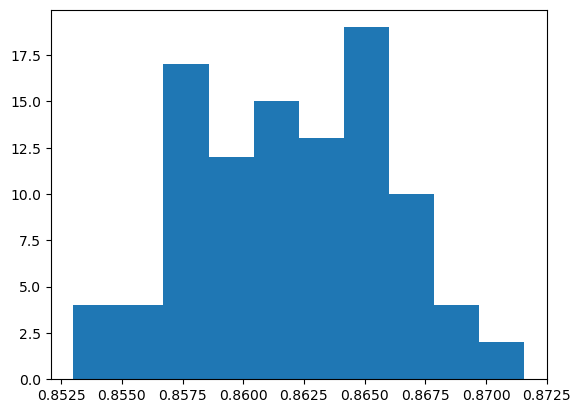

In [31]:
plt.hist(auc_boot)

print(np.mean(auc_boot))

np.quantile(auc_boot, [0.025, 0.975])